---
# Imports
---

## Libraries
---

In [1]:
library(tidyverse)
library(strengejacke)

#library(Hmisc) # cut2

library(lme4)
library(lmerTest)


# Load helper functions
# library(devtools)
# source_url("https://raw.githubusercontent.com/hauselin/hausekeep/master/R/summaryh.R")

## set universal plot size:
options(repr.plot.width=7, repr.plot.height=3.5)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: tools
Loading sj!-packages: ggeffects
Loading sj!-packages: sjlabelled
Loading sj!-packages: sjmisc
Loading sj!-packages: sjstats
Loading sj!-packages: sjPlot
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



---
## Data
---

### Load
---
Already Cleaned

**++ADD cleaning parameters** to `ma_clean_data` file

---

In [2]:
load("data/swap_v1_clean.RData")
load("data/swap_v2_clean.RData")

# rename for simplicity
v1 = swap_v1_clean
v2 = swap_v2_clean
# clean up
rm(swap_v1_clean, swap_v2_clean)

v301_long = readRDS("data/v301_clean.rds")
v302_long = readRDS("data/v302_clean.rds")
v310_long = readRDS("data/v310_clean.rds")
v311_long = readRDS('data/v311_clean.rds')

In [3]:
# additional versions for two v310 conditions
v310_long_notp = filter(v310_long, condition=='no_tp')
v310_long_tp = filter(v310_long, condition=='tp')

In [4]:
v301 = v301_long[!duplicated(v301_long[,c("subject","trial")]),]
v302 = v302_long[!duplicated(v302_long[,c("subject","trial")]),]
v310 = v310_long[!duplicated(v310_long[,c("subject","trial")]),]
v311 = v311_long[!duplicated(v311_long[,c("subject","trial")]),]

In [5]:
# indicate which version the experiment is
v1$version = 'v1'
v2$version = 'v2'
v301$version = 'v301'
v302$version = 'v302'
v310$version = 'v310'
v311$version = 'v311'

---
### Format
---

In [6]:
# Bin responses by summed val
v1$bin = Hmisc::cut2(v1$summedVal, g=19, levels.mean=TRUE, digits=2)
v2$bin = Hmisc::cut2(v2$summedVal, g=19, levels.mean=TRUE, digits=2)
v301$bin = Hmisc::cut2(v301$summed_val_total, g=19, levels.mean=TRUE, digits=2)
v302$bin = Hmisc::cut2(v302$summed_val_total, g=19, levels.mean=TRUE, digits=2)
v310$bin = Hmisc::cut2(v310$summed_val_total, g=19, levels.mean=TRUE, digits=2)
v311$bin = Hmisc::cut2(v311$summed_val_total, g=19, levels.mean=TRUE, digits=2)

# Bin responses by abs val
v1$bin_abs = Hmisc::cut2(abs(v1$summedVal), g=10, levels.mean=TRUE, digits=2)
v2$bin_abs = Hmisc::cut2(abs(v2$summedVal), g=10, levels.mean=TRUE, digits=2)
v301$bin_abs = Hmisc::cut2(abs(v301$summed_val_total), g=10, levels.mean=TRUE, digits=2)
v302$bin_abs = Hmisc::cut2(abs(v302$summed_val_total), g=10, levels.mean=TRUE, digits=2)
v310$bin_abs = Hmisc::cut2(abs(v310$summed_val_total), g=10, levels.mean=TRUE, digits=2)
v311$bin_abs = Hmisc::cut2(abs(v311$summed_val_total), g=10, levels.mean=TRUE, digits=2)

In [9]:
# subdivide 310 into tp and no tp
v310_notp = filter(v310, condition=='no_tp')
v310_tp = filter(v310, condition=='tp')

v310_notp$version = 'v310_notp'
v310_tp$version = 'v310_tp'

---
# Psychometrics
---

## RT

by Abs. Offer Value

---

### Comparisons
---

In [13]:
df = v311 %>%
        group_by(condition, subject, bin_abs) %>%
        summarise(rt = mean(rt)) %>%
        group_by(condition, bin_abs) %>%
        summarise(N = length(rt),
                  rt_se = sd(rt) / sqrt(length(unique(v311$subject))),
                  rt = mean(rt)
                 ) %>%
        mutate(bin_abs = round(as.numeric(as.character(bin_abs)), 2))

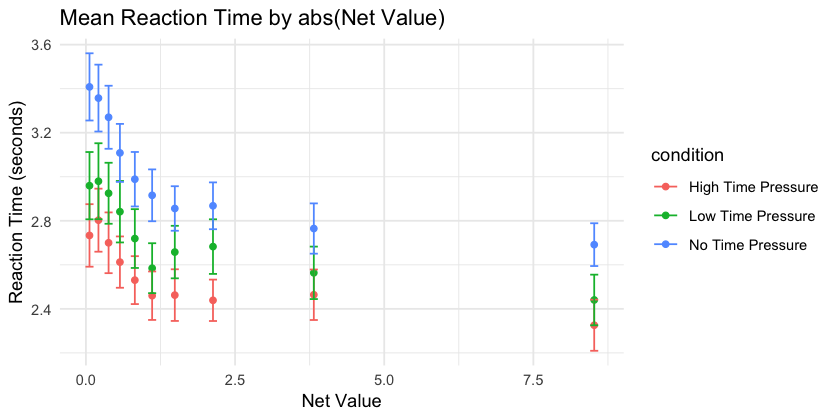

In [14]:
# plot
ggplot(data = df,aes(x = bin_abs,y = rt, colour=condition)) + 
      geom_point() + 
      #geom_line() +
      geom_errorbar(aes(ymin = rt-rt_se,ymax = rt+rt_se)) + 
      labs(x = "Net Value", y = "Reaction Time (seconds)") +
      theme_minimal() +
      ggtitle("Mean Reaction Time by abs(Net Value)")

---
## Fixations
by Abs. Offer Value

---

### Function
---

In [38]:
fix_func = function(df) {
    subjects = length(unique(df$subject))

    fix = df %>%
        group_by(subject, bin_abs) %>%
        summarise(swaps = mean(swapAmount)) %>%
        group_by(bin_abs) %>%
        summarise(N = length(swaps),
                  fix_se = sd(swaps) / sqrt(subjects),
                  fix_num = mean(swaps)
                 ) %>%
        mutate(bin_abs = round(as.numeric(as.character(bin_abs)), 2))

    #head(fix, 3)
    
    ggplot(data = fix,aes(x = bin_abs,y = fix_num)) + 
      geom_point() + 
      #geom_line() +
      geom_errorbar(aes(ymin = fix_num-fix_se,ymax = fix_num+fix_se)) + 
      labs(x = "Net Value", y = "Fixations (count)") +
      theme_minimal() +
      ggtitle("Mean Fixation Count by abs(Net Value)")
    
    #return(fix)
}

---
### Comparisons
---

In [19]:
df = v311 %>%
        group_by(condition, subject, bin_abs) %>%
        summarise(swaps = mean(total_stim_fix)) %>%
        group_by(condition, bin_abs) %>%
        summarise(N = length(swaps),
                      fix_se = sd(swaps) / sqrt(length(unique(v311$subject))),
                      fix_num = mean(swaps)
                     ) %>%
        mutate(bin_abs = round(as.numeric(as.character(bin_abs)), 2))

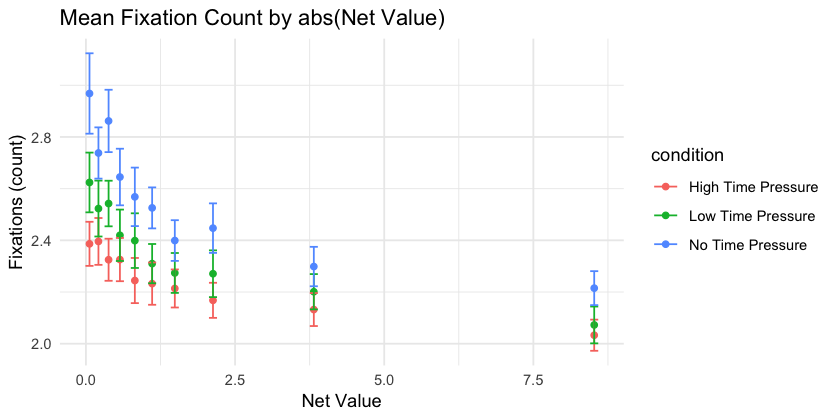

In [20]:
# plot
ggplot(data = df,aes(x = bin_abs,y = fix_num, colour=condition)) + 
      geom_point() + 
      #geom_line() +
      geom_errorbar(aes(ymin = fix_num-fix_se,ymax = fix_num+fix_se)) + 
      labs(x = "Net Value", y = "Fixations (count)") +
      theme_minimal() +
      ggtitle("Mean Fixation Count by abs(Net Value)")

---
## P(Accept)
by Offer Value

---

### Comparisons
---

In [26]:
df = v311 %>%
        group_by(condition, subject, bin) %>%
        summarise(accept = mean(response)) %>%
        group_by(condition, bin) %>%
        summarise(N = length(accept),
                      accept_se = sd(accept, na.rm=TRUE) / sqrt(length(unique(v311$subject))),
                      accept = mean(accept)
                     ) %>%
        mutate(bin = round(as.numeric(as.character(bin)), 2))

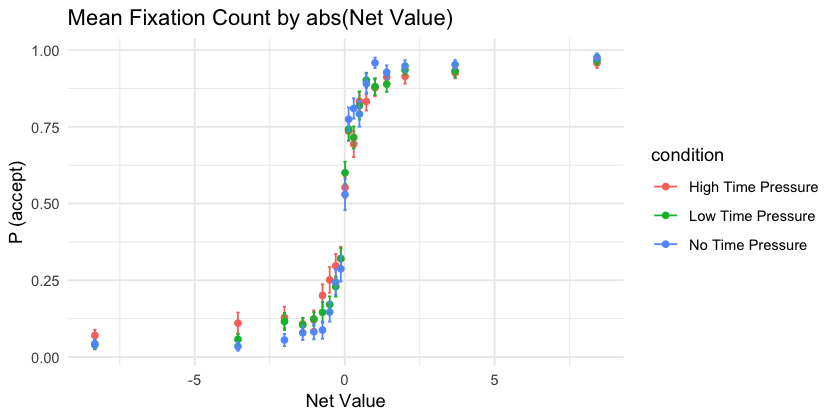

In [27]:
ggplot(data = df, aes(x = bin,y = accept, colour=condition)) + 
      geom_point() + 
      #geom_line() +
      geom_errorbar(aes(ymin = accept-accept_se, ymax = accept+accept_se)) + 
      labs(x = "Net Value", y = "P (accept)") +
      theme_minimal() +
      ggtitle("Mean Fixation Count by abs(Net Value)")

---
# Performance
---

## By Version
---

In [29]:
v311 %>%
    group_by(condition) %>%
    summarise(accuracy = mean(correct))

condition,accuracy
High Time Pressure,0.8204191
Low Time Pressure,0.8426085
No Time Pressure,0.8840185


---
# Attention
---

## First Fixation
---

### Duration
---

In [30]:
first_fix_plot = function(df_long){
    # get first fix val and mult
    df = df_long %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)
    
    #RT vs. Summed Value
    ggplot() +
      geom_smooth(aes(x=fix_stim_val_base, y=fix_rt, 
                      group = factor(fix_stim_mult), 
                      colour = factor(fix_stim_mult)), df) +
      coord_cartesian(xlim = c(-1, 1))  +
      geom_smooth() +  # Add a loess smoothed fit curve with confidence region
      theme_minimal()+
      guides(colour=guide_legend("Multiplier \nCondition")) +
      scale_x_continuous(name="Base Value ($)", seq(-1,1,0.25), limits = c(-1,1))+
      scale_y_continuous(name = "Reaction Time (s)") +
      ggtitle("Mean Fixation Duration by Base Value and Multiplier")
}

first_fix_plot_abs = function(df_long){
    # get first fix val and mult
    df = df_long %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)
    
    #RT vs. Summed Value
    ggplot() +
      geom_smooth(aes(x=abs(fix_stim_val_base), y=fix_rt, 
                      group = factor(fix_stim_mult), 
                      colour = factor(fix_stim_mult)), df) +
      coord_cartesian(xlim = c(0, 1))  +
      geom_smooth() +  # Add a loess smoothed fit curve with confidence region
      theme_minimal()+
      guides(colour=guide_legend("Multiplier \nCondition")) +
      scale_x_continuous(name="Absolute Base Value ($)", seq(0,1,0.25), limits = c(0,1))+
      scale_y_continuous(name = "Reaction Time (s)") +
      ggtitle("Mean Fixation Duration by abs(Base Value) and Multiplier")
}

---
#### No Time Pressure
---

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


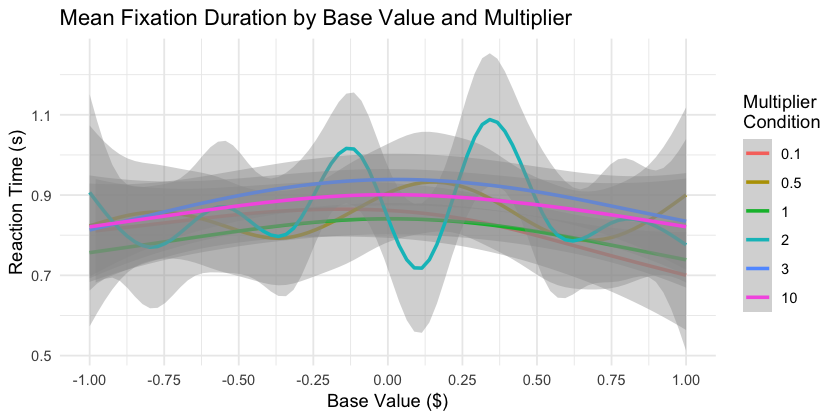

In [33]:
first_fix_plot(filter(v311_long, condition=='No Time Pressure'))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


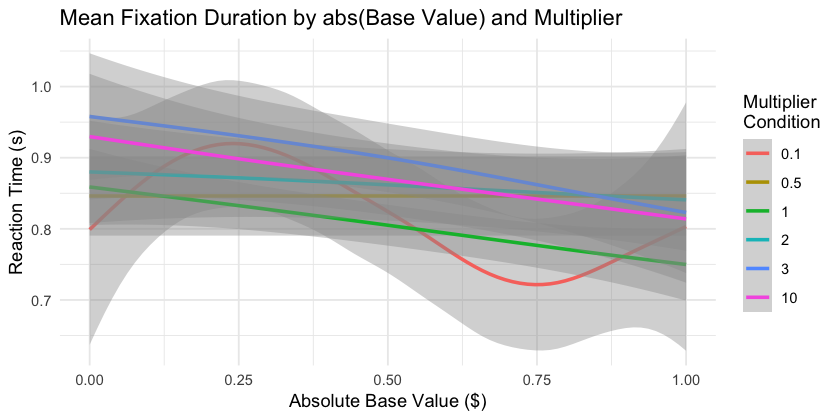

In [34]:
first_fix_plot_abs(filter(v311_long, condition=='No Time Pressure'))

In [35]:
x = v311_long %>%
        filter(condition=='No Time Pressure' & which_fix == 1) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [36]:
x$abs_base_val_1 = abs(x$fix_stim_val_base)
x$mult_1 = x$fix_stim_mult

In [40]:
#Test for SIG
v311_no_tp.lmer <- lmer (fix_rt ~ abs_base_val_1 * mult_1 + (0 + abs_base_val_1|subject) + (1|subject), 
                     data = x)
summary(v311_no_tp.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_1 * mult_1 + (0 + abs_base_val_1 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 4322.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3971 -0.5478 -0.2078  0.2258 10.1129 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_1 0.01717  0.1310  
 subject.1 (Intercept)    0.07233  0.2689  
 Residual                 0.19037  0.4363  
Number of obs: 3520, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            8.978e-01  4.939e-02  3.751e+01  18.178  < 2e-16 ***
abs_base_val_1        -1.288e-01  3.973e-02  6.147e+01  -3.242  0.00192 ** 
mult_1                 9.743e-03  4.795e-03  3.477e+03   2.032  0.04223 *  
abs_base_val_1:mult_1 -8.771e-03  8.369e-03  3.481e+03  -1.048  0.29469    
---
Signif. codes:  0 ‘***’ 0.001 

---
#### Lo Time Pressure
---

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


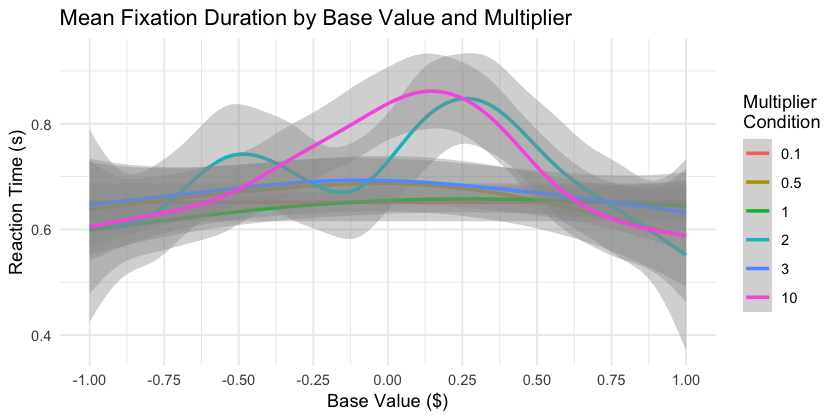

In [41]:
first_fix_plot(filter(v311_long, condition=='Low Time Pressure'))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


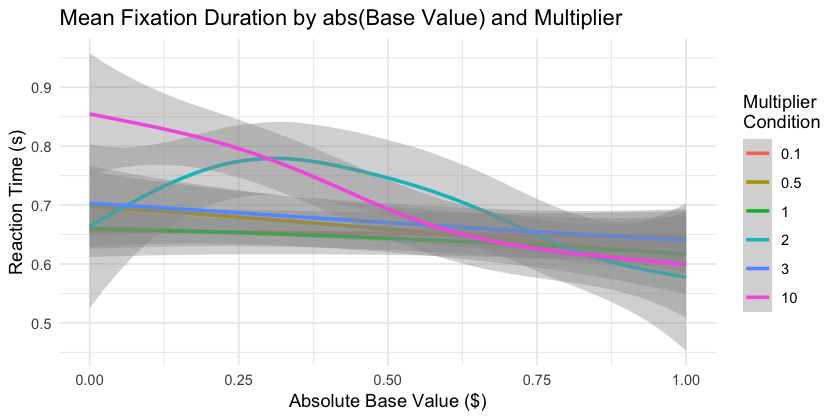

In [42]:
first_fix_plot_abs(filter(v311_long, condition=='Low Time Pressure'))

In [43]:
x = v311_long %>%
        filter(condition=='Low Time Pressure' & which_fix == 1) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [44]:
x$abs_base_val_1 = abs(x$fix_stim_val_base)
x$mult_1 = x$fix_stim_mult

In [45]:
#Test for SIG
v311_lo_tp.lmer <- lmer (fix_rt ~ abs_base_val_1 * mult_1 + (0 + abs_base_val_1|subject) + (1|subject), 
                     data = x)
summary(v311_lo_tp.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_1 * mult_1 + (0 + abs_base_val_1 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 1176.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7253 -0.4846 -0.1186  0.2459  9.3596 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_1 0.03868  0.1967  
 subject.1 (Intercept)    0.10103  0.3179  
 Residual                 0.07391  0.2719  
Number of obs: 3918, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            7.057e-01  5.491e-02  3.510e+01  12.853 7.81e-15 ***
abs_base_val_1        -8.690e-02  3.849e-02  4.112e+01  -2.257   0.0294 *  
mult_1                 8.959e-03  2.853e-03  3.875e+03   3.140   0.0017 ** 
abs_base_val_1:mult_1 -1.223e-02  4.834e-03  3.876e+03  -2.531   0.0114 *  
---
Signif. codes:  0 ‘***’ 0.001 

---
#### Hi Time Pressure
---

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


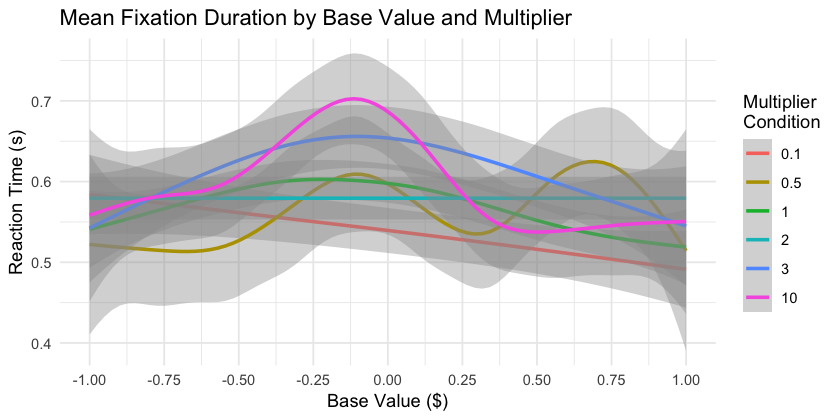

In [46]:
first_fix_plot(filter(v311_long, condition=='High Time Pressure'))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


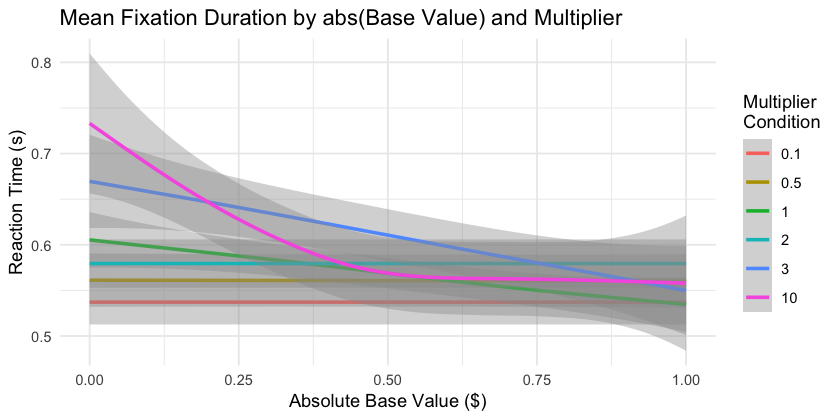

In [47]:
first_fix_plot_abs(filter(v311_long, condition=='High Time Pressure'))

In [48]:
x = v311_long %>%
        filter(condition=='High Time Pressure' & which_fix == 1) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [49]:
x$abs_base_val_1 = abs(x$fix_stim_val_base)
x$mult_1 = x$fix_stim_mult

In [50]:
#Test for SIG
v311_hi_tp.lmer <- lmer (fix_rt ~ abs_base_val_1 * mult_1 + (0 + abs_base_val_1|subject) + (1|subject), 
                     data = x)
summary(v311_hi_tp.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_1 * mult_1 + (0 + abs_base_val_1 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: -1204.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1562 -0.4870 -0.1099  0.3139 10.0465 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_1 0.02567  0.1602  
 subject.1 (Intercept)    0.06731  0.2594  
 Residual                 0.04022  0.2006  
Number of obs: 3953, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.984e-01  4.462e-02  3.495e+01  13.412 2.41e-15 ***
abs_base_val_1        -5.799e-02  3.054e-02  4.114e+01  -1.899  0.06460 .  
mult_1                 9.073e-03  2.048e-03  3.903e+03   4.431 9.65e-06 ***
abs_base_val_1:mult_1 -1.047e-02  3.558e-03  3.907e+03  -2.943  0.00326 ** 
---
Signif. codes:  0 ‘***’ 0.001

---
#### Comparisons
---

##### Table
---

In [51]:
tab_model(v311_no_tp.lmer, v311_lo_tp.lmer, v311_hi_tp.lmer, 
          show.aic = T, 
          show.ci = F,
          dv.labels = c('No TP', 'Low TP', 'High TP'),
          pred.labels= c('Intercept', 'Base Value', 'Multiplier', 'Base Value:Multiplier'),
          title="First Fixation: Duration")

---
##### Plot
---

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_errorbar).”

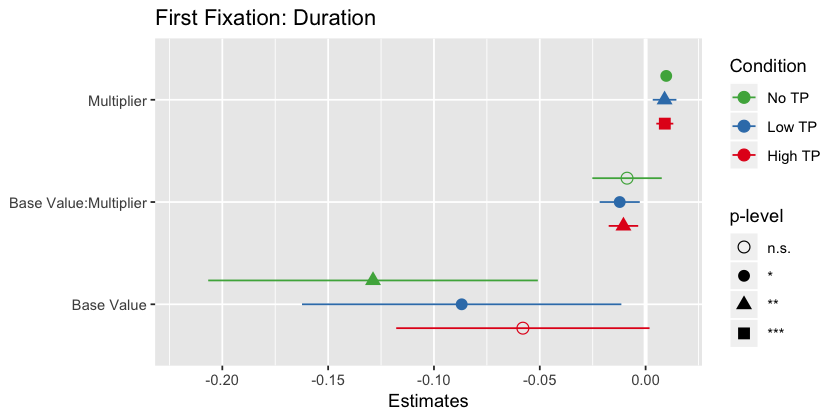

In [56]:
plot_models(v311_no_tp.lmer, v311_lo_tp.lmer, v311_hi_tp.lmer,
            show.p=TRUE,
            p.shape=TRUE,
            spacing=0.7,
            axis.labels = c("Base Value", "Base Value:Multiplier", "Multiplier"),
            legend.title='Condition',
            m.labels=c('No TP', 'Low TP', 'High TP'),
            title="First Fixation: Duration")  +  
ylim(-0.22, .015) 


---
## First Mult
---

### No TP
---

In [57]:
# trials where they did not look at any stim
filter(v311_long, condition=='No Time Pressure') %>%
        filter(total_stim_fix == 0) %>%
        group_by(subject)%>%
        summarise(N = length(unique(trial)))

subject,N
154,1
160,1
176,1
179,2
186,1
197,1


In [58]:
# percent left first
side_1 = filter(v311_long, condition=='No Time Pressure') %>%
        filter(which_fix == 1) %>%
        group_by(subject) %>%
        summarise(left = sum(fix_stim=='left'),
                  right = sum(fix_stim=='right'),
                  pct_left_1 = sum(fix_stim=='left')/(sum(fix_stim=='left') + sum(fix_stim=='right'))) %>%
        select(subject, left, right, pct_left_1)

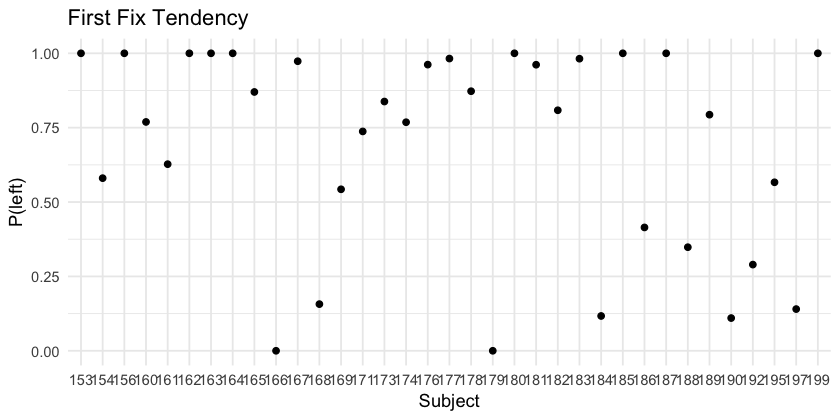

In [59]:
ggplot(side_1, aes(factor(subject), pct_left_1)) + 
    geom_point() +
    labs(title = "First Fix Tendency", x = "Subject", y = "P(left)") +
    theme_minimal()

In [60]:
x = filter(v311_long, condition=='No Time Pressure') %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_stim, left_mult_pull)

In [61]:
v311_no_tp_1.glmer <- glmer(factor(fix_stim) ~ left_mult_pull + (1 + left_mult_pull | subject), 
                    data = x, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v311_no_tp_1.glmer)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(fix_stim) ~ left_mult_pull + (1 + left_mult_pull | subject)
   Data: x
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  2074.7   2105.5  -1032.3   2064.7     3515 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7967 -0.2811 -0.0454  0.1057  8.1487 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 subject (Intercept)    17.36560 4.167         
         left_mult_pull  0.08583 0.293    -0.19
Number of obs: 3520, groups:  subject, 35

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.41361    0.72362  -3.335 0.000852 ***
left_mult_pull -0.16795    0.05547  -3.028 0.002463 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lft_mlt_pll -0.130

---
### Low TP
---

In [62]:
# trials where they did not look at any stim
filter(v311_long, condition=='Low Time Pressure') %>%
        filter(total_stim_fix == 0) %>%
        group_by(subject)%>%
        summarise(N = length(unique(trial)))

subject,N
168,1
169,1
181,1
189,1
190,1


In [63]:
# percent left first
side_1 = filter(v311_long, condition=='Low Time Pressure') %>%
        filter(which_fix == 1) %>%
        group_by(subject) %>%
        summarise(left = sum(fix_stim=='left'),
                  right = sum(fix_stim=='right'),
                  pct_left_1 = sum(fix_stim=='left')/(sum(fix_stim=='left') + sum(fix_stim=='right'))) %>%
        select(subject, left, right, pct_left_1)

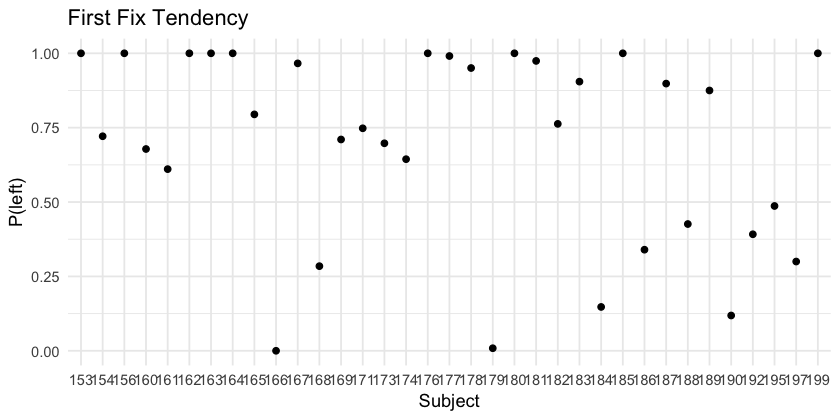

In [64]:
ggplot(side_1, aes(factor(subject), pct_left_1)) + 
    geom_point() +
    labs(title = "First Fix Tendency", x = "Subject", y = "P(left)") +
    theme_minimal()

In [66]:
x = filter(v311_long, condition=='Low Time Pressure') %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_stim, left_mult_pull)

In [67]:
v311_lo_tp_1.glmer <- glmer(factor(fix_stim) ~ left_mult_pull + (0 + left_mult_pull | subject) + (1|subject), 
                    data = x, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v311_lo_tp_1.glmer)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(fix_stim) ~ left_mult_pull + (0 + left_mult_pull | subject) +  
    (1 | subject)
   Data: x
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  2321.4   2346.5  -1156.7   2313.4     3914 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-30.7147  -0.2839  -0.0426   0.0827  21.9711 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   left_mult_pull  0.4838  0.6956  
 subject.1 (Intercept)    17.6527  4.2015  
Number of obs: 3918, groups:  subject, 35

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.5633     0.7247  -3.537 0.000405 ***
left_mult_pull  -0.2983     0.1156  -2.580 0.009868 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lft_mlt_pll -0.008

---
### High TP
---

In [68]:
# trials where they did not look at any stim
filter(v311_long, condition=='High Time Pressure') %>%
        filter(total_stim_fix == 0) %>%
        group_by(subject)%>%
        summarise(N = length(unique(trial)))

subject,N
161,1
169,2
184,1
186,1


In [69]:
# percent left first
side_1 = filter(v311_long, condition=='High Time Pressure') %>%
        filter(which_fix == 1) %>%
        group_by(subject) %>%
        summarise(left = sum(fix_stim=='left'),
                  right = sum(fix_stim=='right'),
                  pct_left_1 = sum(fix_stim=='left')/(sum(fix_stim=='left') + sum(fix_stim=='right'))) %>%
        select(subject, left, right, pct_left_1)

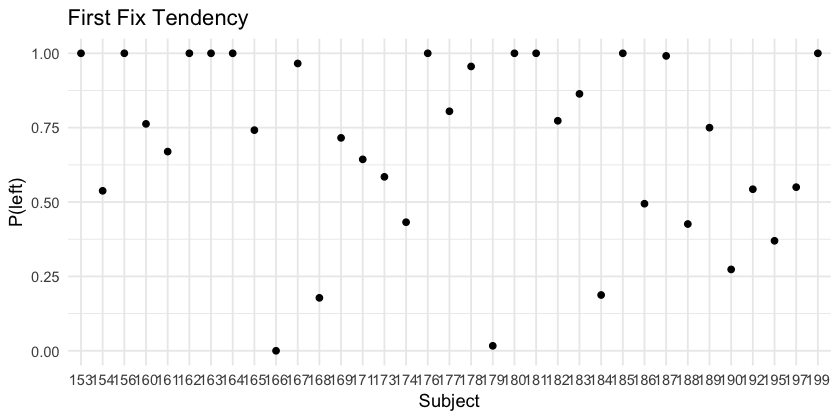

In [70]:
ggplot(side_1, aes(factor(subject), pct_left_1)) + 
    geom_point() +
    labs(title = "First Fix Tendency", x = "Subject", y = "P(left)") +
    theme_minimal()

In [72]:
x = filter(v311_long, condition=='High Time Pressure') %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_stim, left_mult_pull)

In [73]:
v311_hi_tp_1.glmer <- glmer(factor(fix_stim) ~ left_mult_pull + (0 + left_mult_pull | subject) + (1|subject), 
                    data = x, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v311_hi_tp_1.glmer)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(fix_stim) ~ left_mult_pull + (0 + left_mult_pull | subject) +  
    (1 | subject)
   Data: x
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  2337.2   2362.4  -1164.6   2329.2     3949 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-23.151  -0.313  -0.034   0.084 168.503 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   left_mult_pull  1.871   1.368   
 subject.1 (Intercept)    23.961   4.895   
Number of obs: 3953, groups:  subject, 35

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.3750     1.0225  -3.301 0.000964 ***
left_mult_pull  -0.4710     0.2353  -2.002 0.045320 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lft_mlt_pll -0.146

---
### Comparisons
---

#### Table
---

In [60]:
tab_model(v311_no_tp_1.glmer, v311_lo_tp_1.glmer, v311_hi_tp_1.glmer, 
          show.aic = T, 
          show.ci = F,
          dv.labels = c('No TP', 'Low TP', 'High TP'),
          pred.labels= c('Intercept', 'Left Mult Pull'),
          title="First Fixation: Mutliplier Choice")

Caution! ICC for random-slope-intercept models usually not meaningful. Use `adjusted = TRUE` to use the mean random effect variance to calculate the ICC. See 'Note' in `?icc`.
Caution! ICC for random-slope-intercept models usually not meaningful. Use `adjusted = TRUE` to use the mean random effect variance to calculate the ICC. See 'Note' in `?icc`.
Caution! ICC for random-slope-intercept models usually not meaningful. Use `adjusted = TRUE` to use the mean random effect variance to calculate the ICC. See 'Note' in `?icc`.


---
#### Plot
---

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


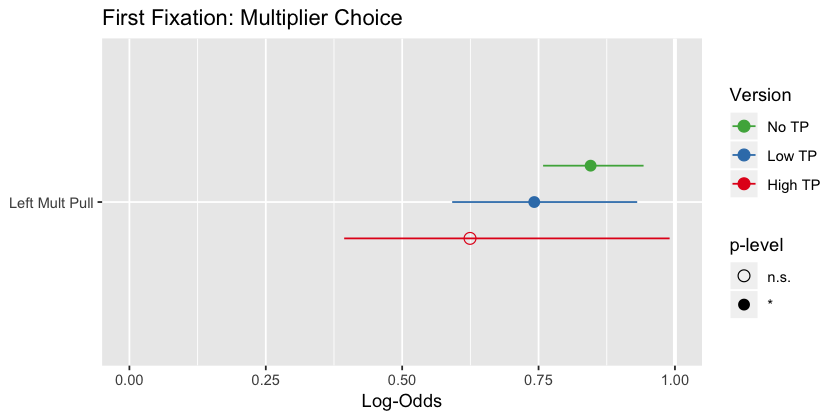

In [78]:
plot_models(v311_no_tp_1.glmer, v311_lo_tp_1.glmer, v311_hi_tp_1.glmer,
            show.p=TRUE,
            p.shape=TRUE,
            axis.labels = c('Left Mult Pull'),
            legend.title='Version',
            m.labels=c('No TP', 'Low TP', 'High TP'),
            title="First Fixation: Multiplier Choice")  +  
ylim(0.0, 1)


---
## Middle (2nd) Fixation
---

### Duration
---

In [79]:
mid_fix_plot = function(df_long){
    # get first fix val and mult
    df = df_long %>%
        filter(which_fix == 2) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)
    
    #RT vs. Summed Value
    ggplot() +
      geom_smooth(aes(x=fix_stim_val_base, y=fix_rt, 
                      group = factor(fix_stim_mult), 
                      colour = factor(fix_stim_mult)), df) +
      coord_cartesian(xlim = c(-1, 1))  +
      geom_smooth() +  # Add a loess smoothed fit curve with confidence region
      theme_minimal()+
      guides(colour=guide_legend("Multiplier \nCondition")) +
      scale_x_continuous(name="Base Value ($)", seq(-1,1,0.25), limits = c(-1,1))+
      scale_y_continuous(name = "Reaction Time (s)") +
      ggtitle("Mean Fixation Duration by Base Value and Multiplier")
}

mid_fix_plot_abs = function(df_long){
    # get first fix val and mult
    df = df_long %>%
        filter(which_fix == 2) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)
    
    #RT vs. Summed Value
    ggplot() +
      geom_smooth(aes(x=abs(fix_stim_val_base), y=fix_rt, 
                      group = factor(fix_stim_mult), 
                      colour = factor(fix_stim_mult)), df) +
      coord_cartesian(xlim = c(0, 1))  +
      geom_smooth() +  # Add a loess smoothed fit curve with confidence region
      theme_minimal()+
      guides(colour=guide_legend("Multiplier \nCondition")) +
      scale_x_continuous(name="Absolute Base Value ($)", seq(0,1,0.25), limits = c(0,1))+
      scale_y_continuous(name = "Reaction Time (s)") +
      ggtitle("Mean Fixation Duration by abs(Base Value) and Multiplier")
}

---
#### No TP
---

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


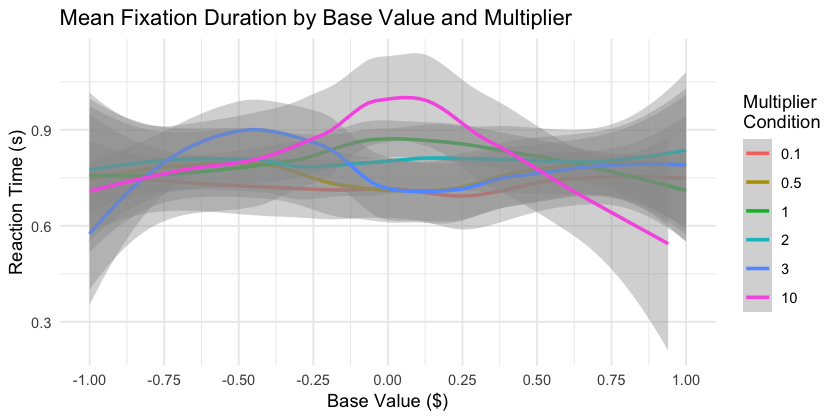

In [81]:
mid_fix_plot(filter(v311_long, condition=='No Time Pressure'))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


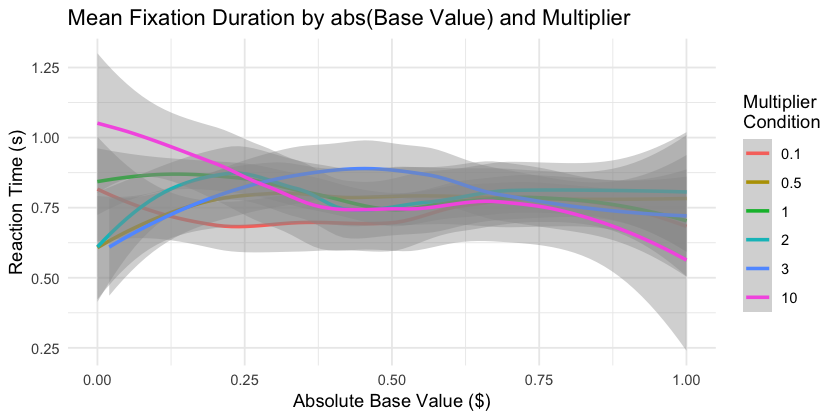

In [82]:
mid_fix_plot_abs(filter(v311_long, condition=='No Time Pressure'))

In [83]:
x = (filter(v311_long, condition=='No Time Pressure')) %>%
        filter(which_fix == 2) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [84]:
x$abs_base_val_2 = abs(x$fix_stim_val_base)
x$mult_2 = x$fix_stim_mult

In [85]:
#Test for SIG
v311_no_tp_2.lmer <- lmer (fix_rt ~ abs_base_val_2 * mult_2 + (0 + abs_base_val_2|subject) + (1|subject), 
                     data = x)
summary(v311_no_tp_2.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_2 * mult_2 + (0 + abs_base_val_2 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 2349

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5684 -0.5735 -0.1387  0.4186  8.8186 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_2 0.01997  0.1413  
 subject.1 (Intercept)    0.06297  0.2509  
 Residual                 0.15676  0.3959  
Number of obs: 2238, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            8.545e-01  4.811e-02  4.067e+01  17.763  < 2e-16 ***
abs_base_val_2        -2.701e-02  4.571e-02  4.664e+01  -0.591  0.55751    
mult_2                 1.944e-02  6.083e-03  2.202e+03   3.195  0.00142 ** 
abs_base_val_2:mult_2 -2.917e-02  1.159e-02  2.201e+03  -2.517  0.01190 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘*

---
#### Low TP
---

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


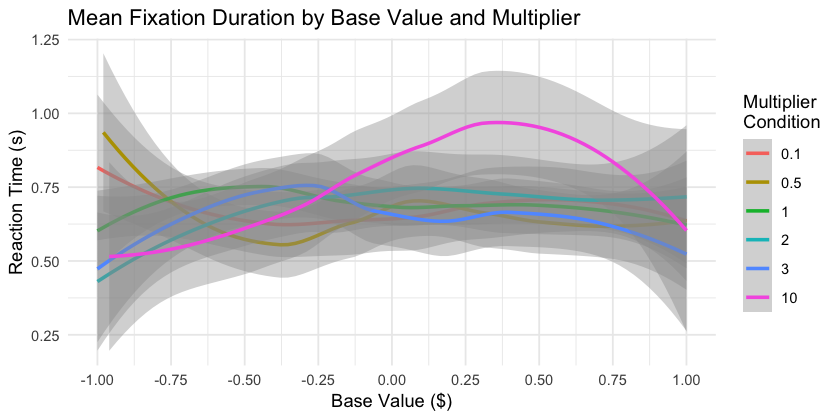

In [86]:
mid_fix_plot(filter(v311_long, condition=='Low Time Pressure'))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


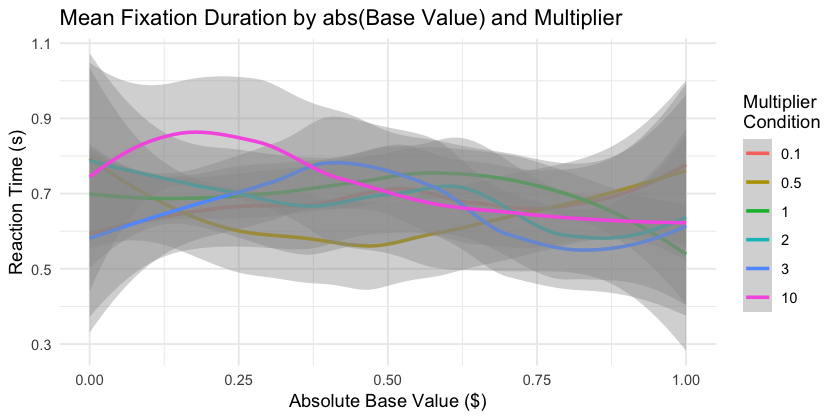

In [88]:
mid_fix_plot_abs(filter(v311_long, condition=='Low Time Pressure'))

In [89]:
x = (filter(v311_long, condition=='Low Time Pressure')) %>%
        filter(which_fix == 2) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [90]:
x$abs_base_val_2 = abs(x$fix_stim_val_base)
x$mult_2 = x$fix_stim_mult

In [92]:
#Test for SIG
v311_lo_tp_2.lmer <- lmer (fix_rt ~ abs_base_val_2 * mult_2 + (0 + abs_base_val_2|subject) + (1|subject), 
                     data = x)
summary(v311_lo_tp_2.lmer)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00343321 (tol = 0.002, component 1)”

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_2 * mult_2 + (0 + abs_base_val_2 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 1216.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7503 -0.5147 -0.0974  0.3858  8.4179 

Random effects:
 Groups    Name           Variance  Std.Dev. 
 subject   abs_base_val_2 9.503e-08 0.0003083
 subject.1 (Intercept)    7.401e-02 0.2720529
 Residual                 1.141e-01 0.3378482
Number of obs: 1643, groups:  subject, 34

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            7.495e-01  5.292e-02  4.270e+01  14.164   <2e-16 ***
abs_base_val_2        -2.244e-02  3.552e-02  1.592e+03  -0.632   0.5277    
mult_2                 1.053e-02  5.714e-03  1.616e+03   1.842   0.0656 .  
abs_base_val_2:mult_2 -9.809e-03  1.043e-02  1.622e+03  -0.940   0.3473    
---
Signif. codes:  0 ‘***

---
#### High TP
---

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


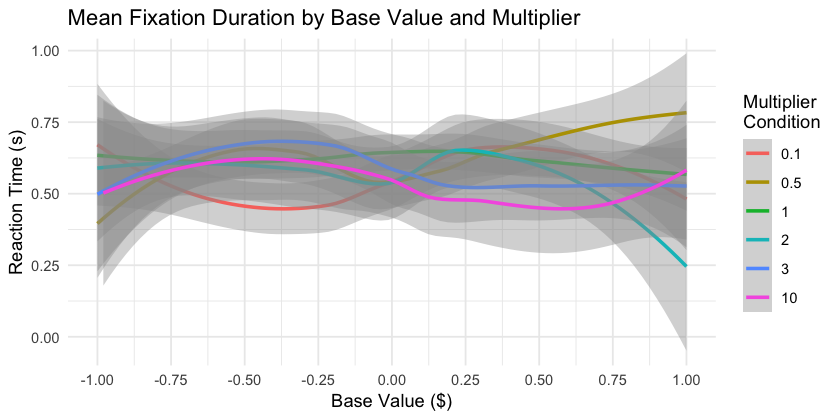

In [93]:
mid_fix_plot(filter(v311_long, condition=='High Time Pressure'))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


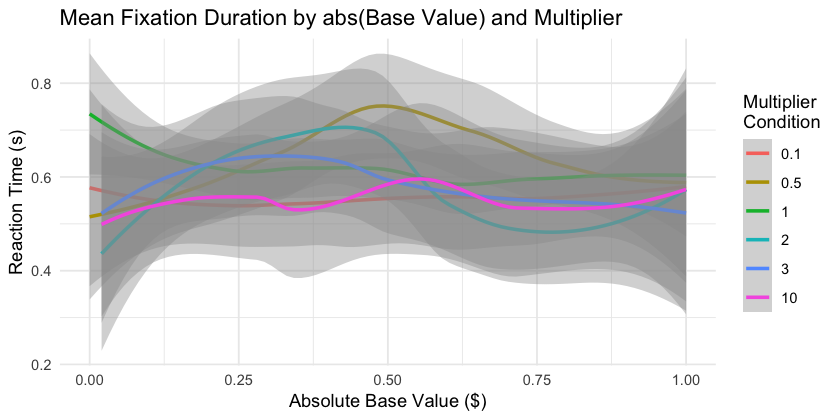

In [94]:
mid_fix_plot_abs(filter(v311_long, condition=='High Time Pressure'))

In [95]:
x = (filter(v311_long, condition=='High Time Pressure')) %>%
        filter(which_fix == 2) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [96]:
x$abs_base_val_2 = abs(x$fix_stim_val_base)
x$mult_2 = x$fix_stim_mult

In [97]:
#Test for SIG
v311_hi_tp_2.lmer <- lmer (fix_rt ~ abs_base_val_2 * mult_2 + (0 + abs_base_val_2|subject) + (1|subject), 
                          data = x)
summary(v311_hi_tp_2.lmer)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00262223 (tol = 0.002, component 1)”

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_2 * mult_2 + (0 + abs_base_val_2 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 267.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9317 -0.5197 -0.0842  0.3967  7.3356 

Random effects:
 Groups    Name           Variance  Std.Dev. 
 subject   abs_base_val_2 2.951e-08 0.0001718
 subject.1 (Intercept)    5.949e-02 0.2439015
 Residual                 6.667e-02 0.2581970
Number of obs: 1186, groups:  subject, 31

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            7.016e-01  4.899e-02  3.797e+01  14.321   <2e-16 ***
abs_base_val_2        -7.295e-02  3.188e-02  1.155e+03  -2.288   0.0223 *  
mult_2                -1.536e-03  5.232e-03  1.159e+03  -0.294   0.7691    
abs_base_val_2:mult_2  5.953e-03  9.489e-03  1.157e+03   0.627   0.5306    
---
Signif. codes:  0 ‘***’

---
#### Comparisons
---

##### Table
---

In [94]:
tab_model(v311_no_tp_2.lmer, v311_lo_tp_2.lmer, v311_hi_tp_2.lmer, 
          show.aic = T, 
          show.ci = F,
          dv.labels = c('No TP', 'Low TP', 'High TP'),
          pred.labels= c('Intercept', 'Base Value', 'Multiplier', 'Base Value:Multiplier'),
          title="Second Fixation: Duration")

---
##### Plot
---

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


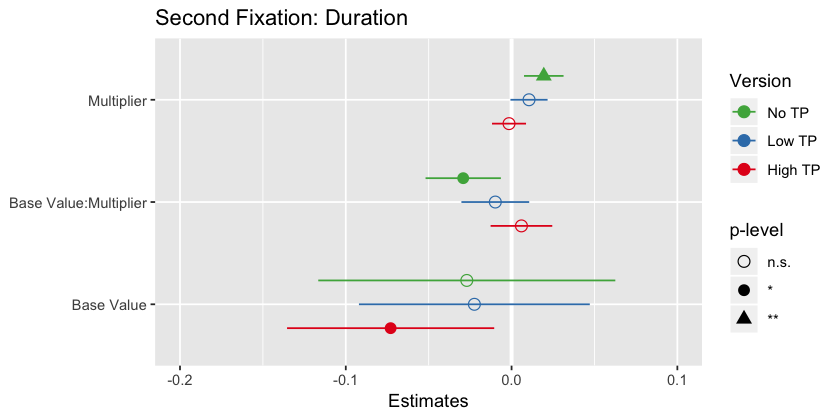

In [99]:
plot_models(v311_no_tp_2.lmer, v311_lo_tp_2.lmer, v311_hi_tp_2.lmer,
            show.p=T,
            p.shape=TRUE,     
            spacing=0.7,
            axis.labels = c("Base Value", "Base Value:Multiplier", "Multiplier"),
            legend.title='Version',
            m.labels=c('No TP', 'Low TP', 'High TP'),
            title="Second Fixation: Duration")  +  
ylim(-.2, .1) 


---
### V3.1.0 notp
---

In [50]:
# trials where they did not look at any stim
v310_long_notp %>%
        filter(total_stim_fix == 0) %>%
        group_by(subject)%>%
        summarise(N = length(unique(trial)))

subject,N
125,1
137,1


In [51]:
# percent left first
side_1 = v310_long_notp %>%
        filter(which_fix == 1) %>%
        group_by(subject) %>%
        summarise(left = sum(fix_stim=='left'),
                  right = sum(fix_stim=='right'),
                  pct_left_1 = sum(fix_stim=='left')/(sum(fix_stim=='left') + sum(fix_stim=='right'))) %>%
        select(subject, left, right, pct_left_1)

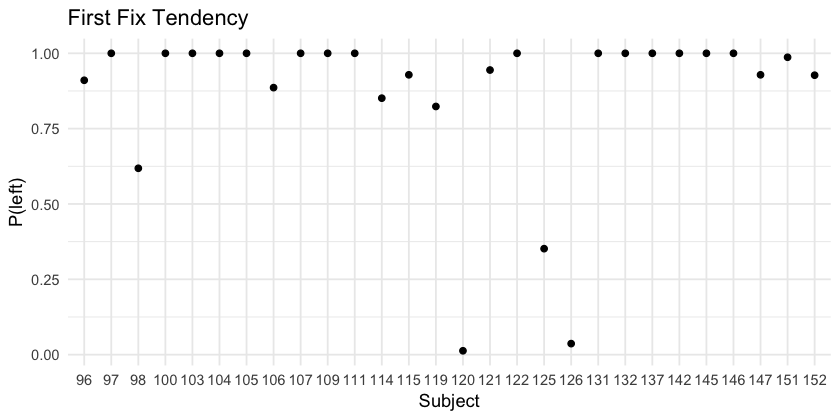

In [52]:
ggplot(side_1, aes(factor(subject), pct_left_1)) + 
    geom_point() +
    labs(title = "First Fix Tendency", x = "Subject", y = "P(left)") +
    theme_minimal()

In [53]:
x = v310_long_notp %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_stim, left_mult_pull)

In [54]:
v310_notp_1.glmer <- glmer(factor(fix_stim) ~ left_mult_pull + (1 + left_mult_pull | subject), 
                    data = x, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v310_notp_1.glmer)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(fix_stim) ~ left_mult_pull + (1 + left_mult_pull | subject)
   Data: x
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
   650.9    678.8   -320.5    640.9     1934 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1162 -0.2371 -0.0165 -0.0141  8.9580 

Random effects:
 Groups  Name           Variance Std.Dev. Corr 
 subject (Intercept)    40.17552 6.3384        
         left_mult_pull  0.09372 0.3061   -0.93
Number of obs: 1939, groups:  subject, 28

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)     -7.3775     2.4866  -2.967  0.00301 **
left_mult_pull   0.1726     0.1691   1.021  0.30747   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lft_mlt_pll -0.667

---
### V3.1.0 tp
---

In [55]:
# trials where they did not look at any stim
v310_long_tp %>%
        filter(total_stim_fix == 0) %>%
        group_by(subject)%>%
        summarise(N = length(unique(trial)))

subject,N
96,1
98,6
106,1
107,1
119,5
125,1
126,2
137,5
142,1
145,1


In [56]:
# percent left first
side_1 = v310_long_tp %>%
        filter(which_fix == 1) %>%
        group_by(subject) %>%
        summarise(left = sum(fix_stim=='left'),
                  right = sum(fix_stim=='right'),
                  pct_left_1 = sum(fix_stim=='left')/(sum(fix_stim=='left') + sum(fix_stim=='right'))) %>%
        select(subject, left, right, pct_left_1)

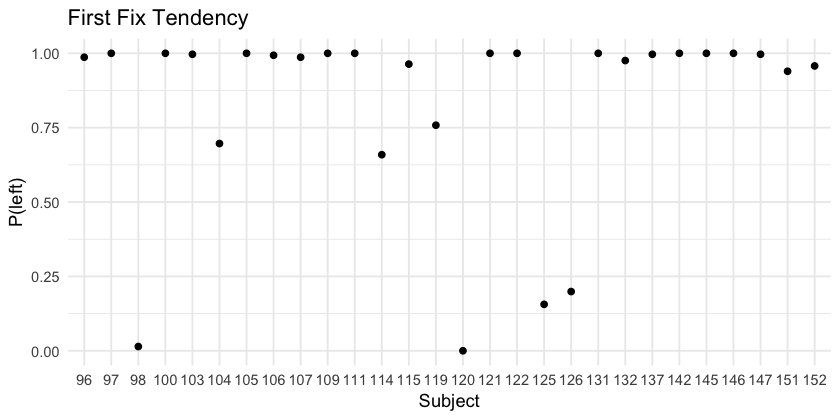

In [57]:
ggplot(side_1, aes(factor(subject), pct_left_1)) + 
    geom_point() +
    labs(title = "First Fix Tendency", x = "Subject", y = "P(left)") +
    theme_minimal()

In [58]:
x = v310_long_tp %>%
        filter(which_fix == 1) %>%
        select(subject, trial, fix_stim, left_mult_pull)

In [59]:
v310_tp_1.glmer <- glmer(factor(fix_stim) ~ left_mult_pull + (0 + left_mult_pull | subject) + (1|subject), 
                    data = x, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v310_tp_1.glmer)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(fix_stim) ~ left_mult_pull + (0 + left_mult_pull | subject) +  
    (1 | subject)
   Data: x
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  2078.7   2106.8  -1035.4   2070.7     8128 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.6057 -0.1080 -0.0178 -0.0167 18.4871 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   left_mult_pull  0.01054 0.1027  
 subject.1 (Intercept)    28.31282 5.3210  
Number of obs: 8132, groups:  subject, 28

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -5.55976    1.29406  -4.296 1.74e-05 ***
left_mult_pull -0.08920    0.03538  -2.521   0.0117 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
lft_mlt_pll 0.034 

---
### Comparisons
---

#### Table
---

In [60]:
tab_model(v301_1.glmer, v302_1.glmer, v310_notp_1.glmer, v310_tp_1.glmer, 
          show.aic = T, 
          show.ci = F,
          dv.labels = c('3.0.1', '3.0.2', '3.1.0 notp', '3.1.0 tp'),
          pred.labels= c('Intercept', 'Left Mult Pull'),
          title="First Fixation: Mutliplier Choice")

Caution! ICC for random-slope-intercept models usually not meaningful. Use `adjusted = TRUE` to use the mean random effect variance to calculate the ICC. See 'Note' in `?icc`.
Caution! ICC for random-slope-intercept models usually not meaningful. Use `adjusted = TRUE` to use the mean random effect variance to calculate the ICC. See 'Note' in `?icc`.
Caution! ICC for random-slope-intercept models usually not meaningful. Use `adjusted = TRUE` to use the mean random effect variance to calculate the ICC. See 'Note' in `?icc`.


---
#### Plot
---

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


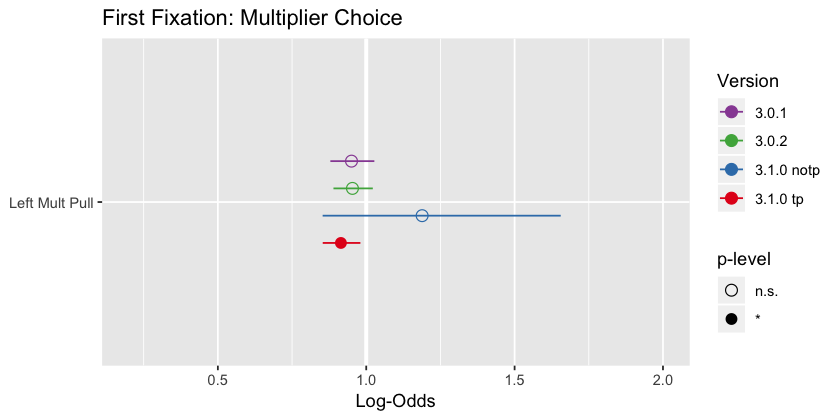

In [61]:
plot_models(v301_1.glmer, v302_1.glmer, v310_notp_1.glmer, v310_tp_1.glmer,
            show.p=TRUE,
            p.shape=TRUE,
            axis.labels = c('Left Mult Pull'),
            legend.title='Version',
            m.labels=c('3.0.1', '3.0.2', '3.1.0 notp', '3.1.0 tp'),
            title="First Fixation: Multiplier Choice")  +  
ylim(0.2, 2)


---
## Final Fixation
---

### Duration
---

In [101]:
final_fix_plot = function(df_long){
    # get first fix val and mult
    df = df_long %>%
        filter(which_fix == 3) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)
    
    #RT vs. Summed Value
    ggplot(df, aes(x=fix_stim_val_base, y=fix_rt, 
                      group = factor(fix_stim_mult), 
                      colour = factor(fix_stim_mult))) +
      coord_cartesian(xlim = c(-1, 1))  +
      geom_smooth() +  # Add a loess smoothed fit curve with confidence region
      theme_minimal()+
      guides(colour=guide_legend("Multiplier \nCondition")) +
      scale_x_continuous(name="Base Value ($)", seq(-1,1,0.25), limits = c(-1,1))+
      scale_y_continuous(name = "Reaction Time (s)") +
      ggtitle("Mean Fixation Duration by Base Value and Multiplier")
}

final_fix_plot_abs = function(df_long){
    # get first fix val and mult
    df = df_long %>%
        filter(which_fix == 3) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)
    
    #RT vs. Summed Value
    ggplot(df, aes(x=abs(fix_stim_val_base), y=fix_rt, 
                      group = factor(fix_stim_mult), 
                      colour = factor(fix_stim_mult)), df) +
      coord_cartesian(xlim = c(0, 1))  +
      geom_smooth() +  # Add a loess smoothed fit curve with confidence region
      theme_minimal()+
      guides(colour=guide_legend("Multiplier \nCondition")) +
      scale_x_continuous(name="Absolute Base Value ($)", seq(0,1,0.25), limits = c(0,1))+
      scale_y_continuous(name = "Reaction Time (s)") +
      ggtitle("Mean Fixation Duration by abs(Base Value) and Multiplier")
}

#### No TP

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


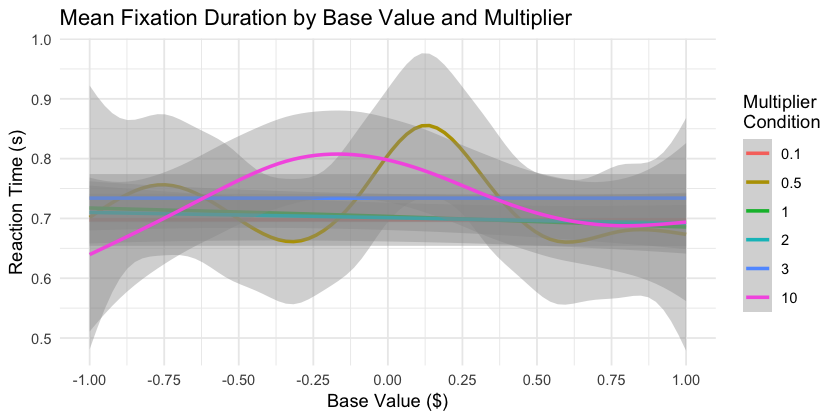

In [102]:
final_fix_plot(filter(v311_long, condition=='No Time Pressure'))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


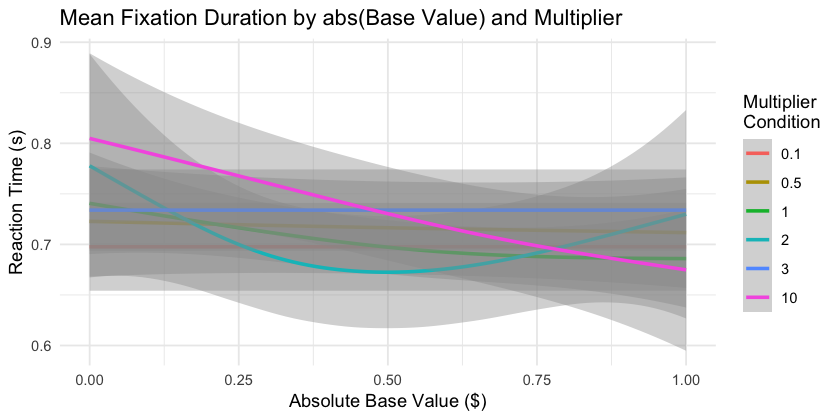

In [104]:
final_fix_plot_abs(filter(v311_long, condition=='No Time Pressure'))

In [109]:
x = (filter(v311_long, condition=='No Time Pressure')) %>%
        filter(which_fix == 3) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [110]:
x$abs_base_val_3 = abs(x$fix_stim_val_base)
x$mult_3 = x$fix_stim_mult

In [111]:
#Test for SIG
v311_no_tp_3.lmer <- lmer (fix_rt ~ abs_base_val_3 * mult_3 + (0 + abs_base_val_3|subject) + (1|subject), 
                     data = x)
summary(v311_no_tp_3.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_3 * mult_3 + (0 + abs_base_val_3 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 3830.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0370 -0.6133 -0.1781  0.4034  7.3489 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_3 0.01128  0.1062  
 subject.1 (Intercept)    0.03713  0.1927  
 Residual                 0.15952  0.3994  
Number of obs: 3666, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            7.252e-01  3.696e-02  4.629e+01  19.624   <2e-16 ***
abs_base_val_3        -4.239e-02  3.465e-02  7.733e+01  -1.223   0.2250    
mult_3                 1.003e-02  4.262e-03  3.638e+03   2.354   0.0186 *  
abs_base_val_3:mult_3 -1.341e-02  7.207e-03  3.617e+03  -1.861   0.0628 .  
---
Signif. codes:  0 ‘***’ 0.001 

---
#### Low TP
---

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


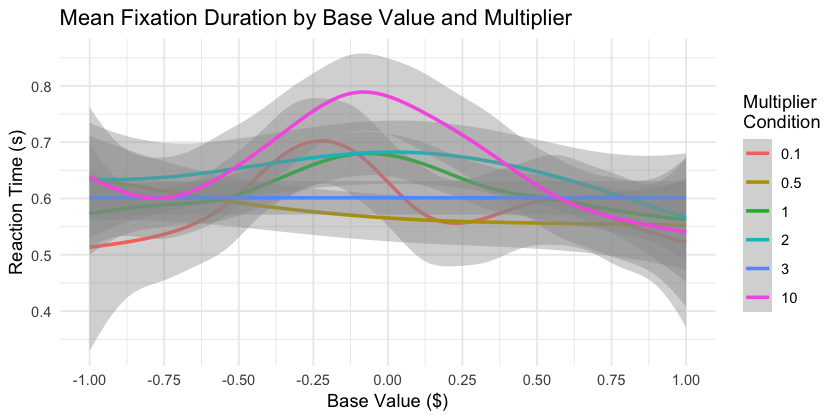

In [112]:
final_fix_plot(filter(v311_long, condition=='Low Time Pressure'))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


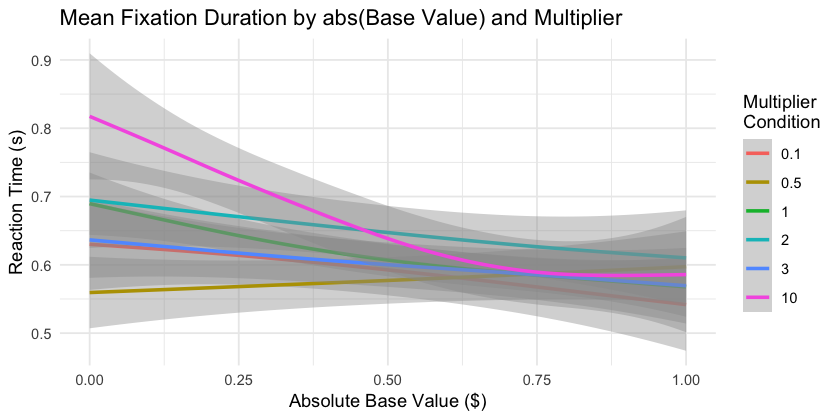

In [113]:
final_fix_plot_abs(filter(v311_long, condition=='Low Time Pressure'))

In [114]:
x = (filter(v311_long, condition=='Low Time Pressure')) %>%
        filter(which_fix == 3) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [115]:
x$abs_base_val_3 = abs(x$fix_stim_val_base)
x$mult_3 = x$fix_stim_mult

In [116]:
#Test for SIG
v311_lo_tp_3.lmer <- lmer (fix_rt ~ abs_base_val_3 * mult_3 + (0 + abs_base_val_3|subject) + (1|subject), 
                     data = x)
summary(v311_lo_tp_3.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_3 * mult_3 + (0 + abs_base_val_3 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 1945.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7960 -0.5490 -0.0944  0.4025  9.2551 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_3 0.01880  0.1371  
 subject.1 (Intercept)    0.06039  0.2457  
 Residual                 0.08947  0.2991  
Number of obs: 4074, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            6.315e-01  4.327e-02  3.642e+01  14.595  < 2e-16 ***
abs_base_val_3        -5.335e-02  3.115e-02  5.046e+01  -1.713 0.092882 .  
mult_3                 1.440e-02  3.075e-03  4.039e+03   4.684 2.91e-06 ***
abs_base_val_3:mult_3 -1.885e-02  5.231e-03  4.040e+03  -3.602 0.000319 ***
---
Signif. codes:  0 ‘***’ 0.001 

---
#### High TP
---

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


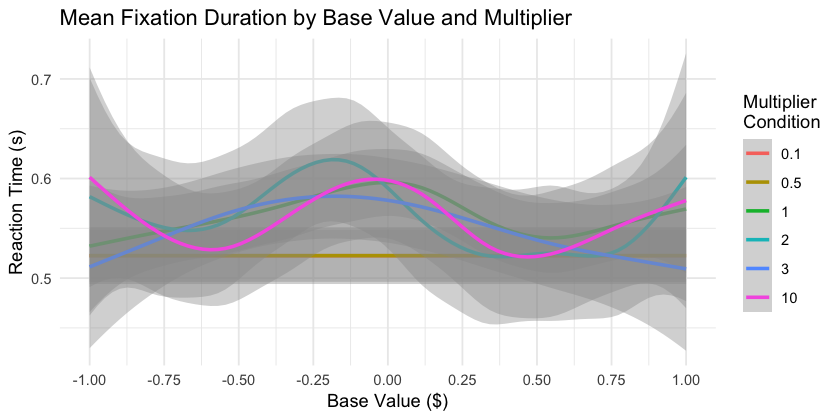

In [117]:
final_fix_plot(filter(v311_long, condition=='High Time Pressure'))

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


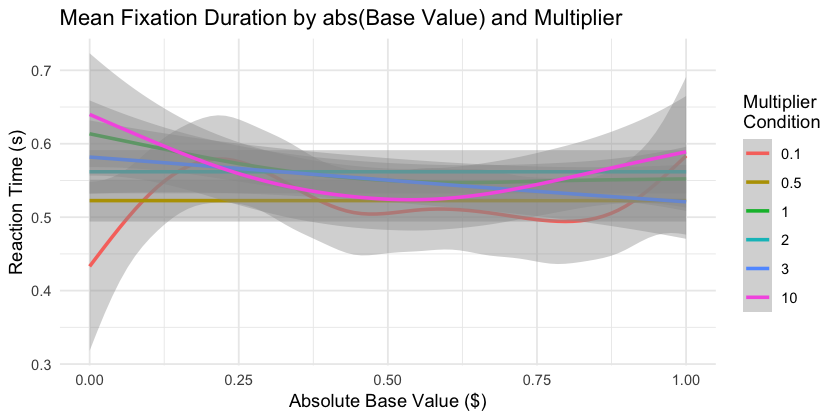

In [118]:
final_fix_plot_abs(filter(v311_long, condition=='High Time Pressure'))

In [119]:
x = (filter(v311_long, condition=='High Time Pressure')) %>%
        filter(which_fix == 3) %>%
        select(subject, trial, fix_rt, fix_stim_val_base, fix_stim_mult)

In [120]:
x$abs_base_val_3 = abs(x$fix_stim_val_base)
x$mult_3 = x$fix_stim_mult

In [121]:
#Test for SIG
v311_hi_tp_3.lmer <- lmer (fix_rt ~ abs_base_val_3 * mult_3 + (0 + abs_base_val_3|subject) + (1|subject), 
                          data = x)
summary(v311_hi_tp_3.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fix_rt ~ abs_base_val_3 * mult_3 + (0 + abs_base_val_3 | subject) +  
    (1 | subject)
   Data: x

REML criterion at convergence: 942.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9634 -0.5334 -0.0725  0.3958 11.1709 

Random effects:
 Groups    Name           Variance Std.Dev.
 subject   abs_base_val_3 0.004919 0.07013 
 subject.1 (Intercept)    0.041825 0.20451 
 Residual                 0.070258 0.26506 
Number of obs: 4099, groups:  subject, 35

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            5.707e-01  3.615e-02  3.681e+01  15.787   <2e-16 ***
abs_base_val_3        -5.234e-02  2.157e-02  6.345e+01  -2.427   0.0181 *  
mult_3                 2.429e-03  2.852e-03  4.050e+03   0.851   0.3946    
abs_base_val_3:mult_3  3.763e-04  4.862e-03  4.038e+03   0.077   0.9383    
---
Signif. codes:  0 ‘***’ 0.001 ‘

---
#### Comparisons
---

##### Table
---

In [130]:
tab_model(v311_no_tp_3.lmer, v311_lo_tp_3.lmer, v311_hi_tp_3.lmer, 
          show.aic = T, 
          show.ci = F,
          dv.labels = c('No TP', 'Low TP', 'High TP'),
          pred.labels= c('Intercept', 'Base Value', 'Multiplier', 'Base Value:Multiplier'),
          title="Final Fixation: Duration")

ERROR: Error in rsq.list[[i]][[2]]: subscript out of bounds


---
##### Plot
---

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


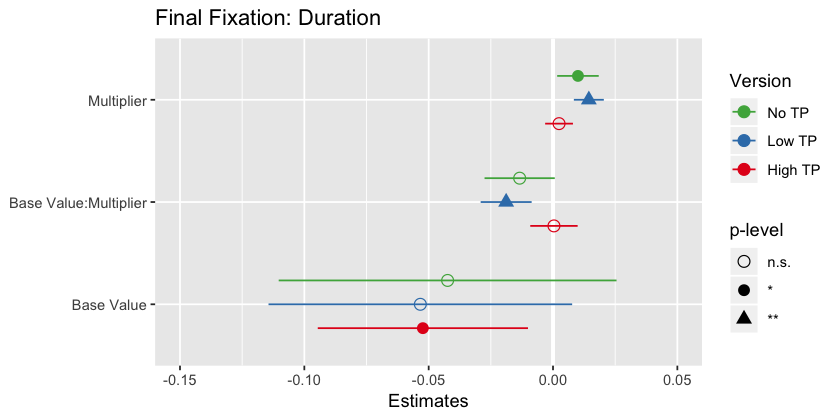

In [123]:
plot_models(v311_no_tp_3.lmer, v311_lo_tp_3.lmer, v311_hi_tp_3.lmer,
            show.p=TRUE,
            p.shape=TRUE,
            spacing=0.7,           
            axis.labels = c("Base Value", "Base Value:Multiplier", "Multiplier"),
            legend.title='Version',
            m.labels=c('No TP', 'Low TP', 'High TP'),
            title="Final Fixation: Duration")  +  
ylim(-.15, .05) 


---
## Mult Difference
---

In [37]:
# Do we spend more time looking at the larger mult?
# Look at total time spent looking at stim as function of the weight difference

---
### No TP
---

In [132]:
# Calculate 

# total left dwell time + base val left
left_fix_total_rt = filter(v311_long, condition=='No Time Pressure') %>%
    filter(fix_stim=='left') %>%
    group_by(subject, trial) %>%
    summarise(left_fix_total_rt = sum(fix_rt),
             left_base_val = mean(fix_stim_val_base))

# total right dwell time + base val right
right_fix_total_rt = filter(v311_long, condition=='No Time Pressure') %>%
    filter(fix_stim=='right') %>%
    group_by(subject, trial) %>%
    summarise(right_fix_total_rt = sum(fix_rt),
             right_base_val = mean(fix_stim_val_base))

In [133]:
# Add to trial data frame
v311_no_tp = merge(x = filter(v311, condition=='No Time Pressure'),
                   y = left_fix_total_rt, by = c("subject", "trial"),
                   all = TRUE)
v311_no_tp = merge(x = filter(v311, condition=='No Time Pressure'),
                   y = right_fix_total_rt, by = c("subject", "trial"),
                   all = TRUE)

In [134]:
# Replace NAs with 0 (in case they didn't look at one of the stim)
v311_no_tp$left_fix_total_rt[is.na(v311_no_tp$left_fix_total_rt)] <- 0.001
v311_no_tp$right_fix_total_rt[is.na(v311_no_tp$right_fix_total_rt)] <- 0.001

ERROR: Error in `$<-.data.frame`(`*tmp*`, left_fix_total_rt, value = numeric(0)): replacement has 0 rows, data has 3673


In [136]:
# Calculate the right mult pull (based on left)
v311_no_tp$right_mult_pull = -1 * v311_no_tp$left_mult_pull

In [137]:
# Calculate proportion of rt focussed left
v311_no_tp$left_fix_bias = v311_no_tp$left_fix_total_rt / (v311_no_tp$left_fix_total_rt + v311_no_tp$right_fix_total_rt)

ERROR: Error in `$<-.data.frame`(`*tmp*`, left_fix_bias, value = numeric(0)): replacement has 0 rows, data has 3673


In [138]:
# look at overall left fixation bias
v311_no_tp %>%
    summarise(mean_left_bias = mean(left_fix_bias))

ERROR: Error in mean(left_fix_bias): object 'left_fix_bias' not found


In [121]:
head(v302, 3)

subject,trial,date,psychopy_version,exp_version,face_version,house_version,left,block,rt,⋯,outlier_rt_MAD,version,bin,bin_abs,left_fix_total_rt,left_base_val,right_fix_total_rt,right_base_val,right_mult_pull,left_fix_bias
41,0,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,3.467,⋯,3.47,v302,0.6125,0.458,1.100,0.32,0.767,0.74,0.0,0.5891805
41,1,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,2.050,⋯,2.05,v302,-1.5963,1.722,0.650,-0.66,0.717,-0.58,-1.5,0.4754938
41,2,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,3.867,⋯,3.87,v302,-0.3854,0.458,2.233,0.26,0.800,-0.70,0.0,0.7362348


#### Model

In [123]:
v302_fix_bias.lmer <- lmer (left_fix_bias ~ left_base_val*right_base_val*left_mult_pull + (0 + left_mult_pull|subject) + (1|subject),
                data = v302)
summary(v302_fix_bias.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: left_fix_bias ~ left_base_val * right_base_val * left_mult_pull +  
    (0 + left_mult_pull | subject) + (1 | subject)
   Data: v302

REML criterion at convergence: -7517

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9241 -0.6551  0.0297  0.6705  3.4625 

Random effects:
 Groups    Name           Variance  Std.Dev.
 subject   left_mult_pull 3.361e-05 0.005798
 subject.1 (Intercept)    6.069e-03 0.077903
 Residual                 1.906e-02 0.138072
Number of obs: 6898, groups:  subject, 23

Fixed effects:
                                              Estimate Std. Error         df
(Intercept)                                  5.419e-01  1.634e-02  2.203e+01
left_base_val                                5.664e-03  2.857e-03  6.851e+03
right_base_val                              -8.722e-04  2.852e-03  6.848e+03
left_mult_pull                               8.421e-03  1.316e-03  2.

---
### V3.1.0 notp
---

In [124]:
# Calculate 

# total left dwell time + base val left
left_fix_total_rt = v310_long_notp %>%
    filter(fix_stim=='left') %>%
    group_by(subject, trial) %>%
    summarise(left_fix_total_rt = sum(fix_rt),
             left_base_val = mean(fix_stim_val_base))

# total right dwell time + base val right
right_fix_total_rt = v310_long_notp %>%
    filter(fix_stim=='right') %>%
    group_by(subject, trial) %>%
    summarise(right_fix_total_rt = sum(fix_rt),
             right_base_val = mean(fix_stim_val_base))

In [125]:
# Add to trial data frame
v310_notp = merge(x = v310_notp, y = left_fix_total_rt, by = c("subject", "trial"), all = TRUE)
v310_notp = merge(x = v310_notp, y = right_fix_total_rt, by = c("subject", "trial"), all = TRUE)

In [126]:
# Replace NAs with 0 (in case they didn't look at one of the stim)
v310_notp$left_fix_total_rt[is.na(v310_notp$left_fix_total_rt)] <- 0.001
v310_notp$right_fix_total_rt[is.na(v310_notp$right_fix_total_rt)] <- 0.001

In [127]:
# Calculate the right mult pull (based on left)
v310_notp$right_mult_pull = -1 * v310_notp$left_mult_pull

In [128]:
# Calculate proportion of rt focussed left
v310_notp$left_fix_bias = v310_notp$left_fix_total_rt / (v310_notp$left_fix_total_rt + v310_notp$right_fix_total_rt)

In [129]:
# look at overall left fixation bias
v310_notp %>%
    summarise(mean_left_bias = mean(left_fix_bias))

mean_left_bias
0.5532501


In [130]:
head(v302, 3)

subject,trial,date,psychopy_version,exp_version,face_version,house_version,left,block,rt,⋯,outlier_rt_MAD,version,bin,bin_abs,left_fix_total_rt,left_base_val,right_fix_total_rt,right_base_val,right_mult_pull,left_fix_bias
41,0,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,3.467,⋯,3.47,v302,0.6125,0.458,1.100,0.32,0.767,0.74,0.0,0.5891805
41,1,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,2.050,⋯,2.05,v302,-1.5963,1.722,0.650,-0.66,0.717,-0.58,-1.5,0.4754938
41,2,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,3.867,⋯,3.87,v302,-0.3854,0.458,2.233,0.26,0.800,-0.70,0.0,0.7362348


#### Model

In [131]:
v310_notp_fix_bias.lmer <- lmer (left_fix_bias ~ left_base_val*right_base_val*left_mult_pull + (0 + left_mult_pull|subject) + (1|subject),
                data = v310_notp)
summary(v310_notp_fix_bias.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: left_fix_bias ~ left_base_val * right_base_val * left_mult_pull +  
    (0 + left_mult_pull | subject) + (1 | subject)
   Data: v310_notp

REML criterion at convergence: -2617

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1379 -0.6486  0.0092  0.6568  3.3535 

Random effects:
 Groups    Name           Variance  Std.Dev.
 subject   left_mult_pull 2.821e-05 0.005312
 subject.1 (Intercept)    7.474e-03 0.086454
 Residual                 1.368e-02 0.116956
Number of obs: 1937, groups:  subject, 28

Fixed effects:
                                              Estimate Std. Error         df
(Intercept)                                  5.524e-01  1.657e-02  2.707e+01
left_base_val                                7.633e-03  4.592e-03  1.889e+03
right_base_val                              -6.258e-03  4.579e-03  1.895e+03
left_mult_pull                               5.839e-03  1.279e-0

---
### V3.1.0 tp
---

In [132]:
# Calculate 

# total left dwell time + base val left
left_fix_total_rt = v310_long_tp %>%
    filter(fix_stim=='left') %>%
    group_by(subject, trial) %>%
    summarise(left_fix_total_rt = sum(fix_rt),
             left_base_val = mean(fix_stim_val_base))

# total right dwell time + base val right
right_fix_total_rt = v310_long_tp %>%
    filter(fix_stim=='right') %>%
    group_by(subject, trial) %>%
    summarise(right_fix_total_rt = sum(fix_rt),
             right_base_val = mean(fix_stim_val_base))

In [133]:
# Add to trial data frame
v310_tp = merge(x = v310_tp, y = left_fix_total_rt, by = c("subject", "trial"), all = TRUE)
v310_tp = merge(x = v310_tp, y = right_fix_total_rt, by = c("subject", "trial"), all = TRUE)

In [134]:
# Replace NAs with 0 (in case they didn't look at one of the stim)
v310_tp$left_fix_total_rt[is.na(v310_tp$left_fix_total_rt)] <- 0.001
v310_tp$right_fix_total_rt[is.na(v310_tp$right_fix_total_rt)] <- 0.001

In [135]:
# Calculate the right mult pull (based on left)
v310_tp$right_mult_pull = -1 * v310_tp$left_mult_pull

In [136]:
# Calculate proportion of rt focussed left
v310_tp$left_fix_bias = v310_tp$left_fix_total_rt / (v310_tp$left_fix_total_rt + v310_tp$right_fix_total_rt)

In [138]:
# look at overall left fixation bias
v310_tp %>%
    summarise(mean_left_bias = mean(left_fix_bias))

mean_left_bias
0.5039787


In [139]:
head(v302, 3)

subject,trial,date,psychopy_version,exp_version,face_version,house_version,left,block,rt,⋯,outlier_rt_MAD,version,bin,bin_abs,left_fix_total_rt,left_base_val,right_fix_total_rt,right_base_val,right_mult_pull,left_fix_bias
41,0,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,3.467,⋯,3.47,v302,0.6125,0.458,1.100,0.32,0.767,0.74,0.0,0.5891805
41,1,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,2.050,⋯,2.05,v302,-1.5963,1.722,0.650,-0.66,0.717,-0.58,-1.5,0.4754938
41,2,2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,0,3.867,⋯,3.87,v302,-0.3854,0.458,2.233,0.26,0.800,-0.70,0.0,0.7362348


#### Model

In [140]:
v310_tp_fix_bias.lmer <- lmer (left_fix_bias ~ left_base_val*right_base_val*left_mult_pull + (0 + left_mult_pull|subject) + (1|subject),
                data = v310_tp)
summary(v310_tp_fix_bias.lmer)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: left_fix_bias ~ left_base_val * right_base_val * left_mult_pull +  
    (0 + left_mult_pull | subject) + (1 | subject)
   Data: v310_tp

REML criterion at convergence: -12724.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6235 -0.6424 -0.0268  0.6313  3.9013 

Random effects:
 Groups    Name           Variance  Std.Dev.
 subject   left_mult_pull 0.0000439 0.006626
 subject.1 (Intercept)    0.0038810 0.062297
 Residual                 0.0118158 0.108701
Number of obs: 8125, groups:  subject, 28

Fixed effects:
                                              Estimate Std. Error         df
(Intercept)                                  5.055e-01  1.184e-02  2.703e+01
left_base_val                                3.117e-03  2.067e-03  8.065e+03
right_base_val                               4.310e-04  2.075e-03  8.063e+03
left_mult_pull                               7.538e-03  1.309e-

---
### Comparisons
---

#### Table
---

In [141]:
tab_model(v301_fix_bias.lmer, v302_fix_bias.lmer, v310_notp_fix_bias.lmer, v310_tp_fix_bias.lmer, 
          show.aic = T, 
          show.ci = F,
          dv.labels = c('3.0.1', '3.0.2', '3.1.0 notp', '3.1.0 tp'),
          pred.labels= c('Intercept', 'Left Mult Pull'),
          title="First Fixation: Mutliplier Choice")

Length of `pred.labels` does not equal number of predictors, no labelling applied.


---
#### Plot
---

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


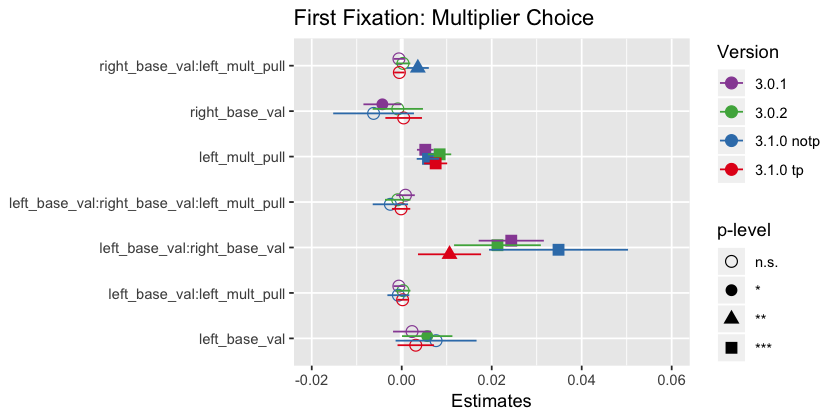

In [147]:
plot_models(v301_fix_bias.lmer, v302_fix_bias.lmer, v310_notp_fix_bias.lmer, v310_tp_fix_bias.lmer,
            show.p=TRUE,
            p.shape=TRUE,
            #axis.labels = c('Left Mult Pull'),
            legend.title='Version',
            m.labels=c('3.0.1', '3.0.2', '3.1.0 notp', '3.1.0 tp'),
            title="First Fixation: Multiplier Choice")  +  
ylim(-0.02, 0.06)


## Choice ~ Total Fix Time on Stim on BOUNDARY choices

# Mult Weights

---
## v1
---

In [224]:
rm(df_w)

In [225]:
# rename so glm syntax stays consistent
v1$face_base = v1$faceVal
v1$house_base = v1$houseVal
v1$house_mult = v1$mult1House
v1$face_mult = v1$mult2Face

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v1, select_columns = c('house_mult', 'face_mult'))

In [226]:
names(v1)

[1] "Trial"           "correct"         "faceVal"         "houseVal"       
 [5] "mult1House"      "mult2Face"       "summedVal"       "earnings"       
 [9] "imageList"       "flip"            "subject"         "origNumber"     
[13] "timings2"        "rt"              "imageSequence"   "acceptReject"   
[17] "valBin"          "valBinAmt"       "valBinCtr"       "choice"         
[21] "fixation_timing" "total_0_face"    "total_1_house"   "lastImage"      
[25] "finalEarnings"   "absDiff"         "swapAmount"      "swapAvg"        
[29] "logRT"           "accuracy"        "absSummedVal"    "multNum"        
[33] "difficulty"      "faceTotal"       "houseTotal"      "faceValBin"     
[37] "faceValBinAmt"   "faceValBinCtr"   "houseValBin"     "houseValBinAmt" 
[41] "houseValBinCtr"  "firstImage"      "firstVal"        "secondVal"      
[45] "firstMult"       "secondMult"      "multDif"         "1_fixation"     
[49] "2_fixation"      "3_fixation"      "4_fixation"      "5_fixation"     
[53] "6_fixation"      "7_fixation"      "8_fixation"      "9_fixation"     
[57] "10_fixation"     "11_fixation"     "12_fixation"     "13_fixation"    
[61] "version"         "bin"             "bin_abs"         "abs_base_val_1" 
[65] "mult_1"          "abs_base_val_2"  "mult_2"          "face_base"      
[69] "house_base"      "mult_house"      "face_mult"       "house_mult"

In [227]:
# apply base value to the dummy code
# 73-75 = house
# 76-78 = face
df_w[,73:75] = df_w[,73:75] * df_w$house_base
df_w[,76:78] = df_w[,76:78] * df_w$face_base

In [228]:
head(df_w,3)

Trial,correct,faceVal,houseVal,mult1House,mult2Face,summedVal,earnings,imageList,flip,⋯,house_base,mult_house,face_mult,house_mult,house_mult_2,house_mult_1,house_mult_3,face_mult_2,face_mult_1,face_mult_3
1,1,0.66,0.86,2,2,3.04,39.60,"[1, 0, 1, 0, 1, 0]",2,⋯,0.86,2,2,2,0.86,0.00,0,0.66,0.00,0.00
2,0,0.38,-0.52,1,1,-0.14,39.46,"[0, 1, 0]",2,⋯,-0.52,1,1,1,0.00,-0.52,0,0.00,0.38,0.00
3,1,0.32,-0.68,1,3,0.28,39.74,"[0, 1, 0]",1,⋯,-0.68,1,3,1,0.00,-0.68,0,0.00,0.00,0.32


In [229]:
v1_weights.glmer <- glmer(choice ~ face_mult_1 + face_mult_2 + face_mult_3 +
                          house_mult_1 + house_mult_2 + house_mult_3 +
                          (0 + face_mult_1 + face_mult_2 + face_mult_3 + 
                           house_mult_1 + house_mult_2 + house_mult_3 |subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v1_weights.glmer)

boundary (singular) fit: see ?isSingular


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ face_mult_1 + face_mult_2 + face_mult_3 + house_mult_1 +  
    house_mult_2 + house_mult_3 + (0 + face_mult_1 + face_mult_2 +  
    face_mult_3 + house_mult_1 + house_mult_2 + house_mult_3 |  
    subject) + (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  4928.6   5125.7  -2435.3   4870.6     6568 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-26.197  -0.406   0.009   0.395  79.271 

Random effects:
 Groups    Name         Variance Std.Dev. Corr                    
 subject   face_mult_1  0.5315   0.7290                           
           face_mult_2  2.7132   1.6472   0.88                    
           face_mult_3  8.0667   2.8402   0.91 0.92               
           house_mult_1 0.6810   0.8252   0.55 0.60 0.52          
           house_mult_2 3.7757  

---
## v2
---

In [246]:
rm(df_w)

In [247]:
# rename so glm syntax stays consistent
v2$face_base = v2$face_val_base
v2$house_base = v2$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v2, select_columns = c('house_mult', 'face_mult'))

In [248]:
names(v2)

[1] "choice"            "correct"           "earnings"         
  [4] "face_mult"         "face_val_base"     "first_image"      
  [7] "house_mult"        "house_val_base"    "image_list"       
 [10] "key_entry_list"    "last_image"        "num_fixations"    
 [13] "participant"       "round_num"         "rt"               
 [16] "rt_list"           "summed_val"        "trial"            
 [19] "face_val_total"    "house_val_total"   "timings"          
 [22] "image_sequence"    "fixation_timing"   "total_fix_face_0" 
 [25] "total_fix_house_1" "final_earnings"    "abs_diff"         
 [28] "fix_num"           "first_val"         "second_val"       
 [31] "first_mult"        "second_mult"       "1_fixation"       
 [34] "2_fixation"        "3_fixation"        "4_fixation"       
 [37] "5_fixation"        "6_fixation"        "7_fixation"       
 [40] "8_fixation"        "9_fixation"        "10_fixation"      
 [43] "11_fixation"       "12_fixation"       "13_fixation"      
 [46] "14_fixation"       "15_fixation"       "16_fixation"      
 [49] "17_fixation"       "18_fixation"       "19_fixation"      
 [52] "20_fixation"       "21_fixation"       "22_fixation"      
 [55] "23_fixation"       "24_fixation"       "25_fixation"      
 [58] "26_fixation"       "27_fixation"       "28_fixation"      
 [61] "29_fixation"       "30_fixation"       "31_fixation"      
 [64] "32_fixation"       "33_fixation"       "34_fixation"      
 [67] "35_fixation"       "36_fixation"       "37_fixation"      
 [70] "38_fixation"       "39_fixation"       "40_fixation"      
 [73] "41_fixation"       "42_fixation"       "43_fixation"      
 [76] "44_fixation"       "45_fixation"       "46_fixation"      
 [79] "47_fixation"       "48_fixation"       "49_fixation"      
 [82] "50_fixation"       "51_fixation"       "52_fixation"      
 [85] "53_fixation"       "summedVal"         "subject"          
 [88] "absSummedVal"      "swapAmount"        "firstMult"        
 [91] "firstVal"          "secondMult"        "secondVal"        
 [94] "faceTotal"         "houseTotal"        "total_0_face"     
 [97] "total_1_house"     "version"           "bin"              
[100] "bin_abs"           "abs_base_val_1"    "mult_1"           
[103] "abs_base_val_2"    "mult_2"            "face_base"        
[106] "house_base"

In [249]:
# apply base value to the dummy code
# 107-112 = house
# 113-118 = face
df_w[,107:112] = df_w[,107:112] * df_w$house_base
df_w[,113:118] = df_w[,113:118] * df_w$face_base

In [250]:
head(df_w,3)

choice,correct,earnings,face_mult,face_val_base,first_image,house_mult,house_val_base,image_list,key_entry_list,⋯,house_mult_1,house_mult_2,house_mult_3,house_mult_10,face_mult_2,face_mult_0.5,face_mult_1,face_mult_3,face_mult_0.1,face_mult_10
0,1,-10.600,2.0,-0.38,1,0.5,-0.72,"[1, 0, 1]","['space', 'space', 'j']",⋯,0.00,0,0,0,-0.38,0.0,0.0,0,0,0
1,1,-10.306,0.5,0.50,0,0.1,0.44,"[0, 1]","['space', 'f']",⋯,0.00,0,0,0,0.00,0.5,0.0,0,0,0
0,1,-10.646,1.0,-0.40,0,1.0,-0.78,"[0, 1, 0, 1]","['space', 'space', 'space', 'j']",⋯,-0.78,0,0,0,0.00,0.0,-0.4,0,0,0


In [251]:
v2_weights.glmer <- glmer(choice ~ face_mult_0.1 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
#                           (0 + face_mult_0.1 + face_mult_0.5 + face_mult_1 + 
#                            face_mult_2 + face_mult_3 + face_mult_10 +
#                            house_mult_0.1 + house_mult_0.5 + house_mult_1 + 
#                            house_mult_2 + house_mult_3 + house_mult_10|subject) + 
                          (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v2_weights.glmer)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ face_mult_0.1 + face_mult_0.5 + face_mult_1 + face_mult_2 +  
    face_mult_3 + face_mult_10 + house_mult_0.1 + house_mult_0.5 +  
    house_mult_1 + house_mult_2 + house_mult_3 + house_mult_10 +  
    (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  8134.2   8237.3  -4053.1   8106.2    11657 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-532.35   -0.36    0.00    0.36   40.12 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.2118   0.4602  
Number of obs: 11671, groups:  subject, 31

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.007424   0.087286  -0.085    0.932    
face_mult_0.1   0.867459   0.118900   7.296 2.97e-13 ***
face_mult_0.5   1.758765   0.134141  13.111  < 2e-16 ***
face_mul

---
## v301
---

In [253]:
rm(df_w)

In [254]:
# rename so glm syntax stays consistent
v301$face_base = v301$face_val_base
v301$house_base = v301$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v301, select_columns = c('house_mult', 'face_mult'))

In [255]:
names(df_w)

[1] "date"                  "psychopy_version"      "exp_version"          
 [4] "face_version"          "house_version"         "left"                 
 [7] "subject"               "block"                 "trial"                
[10] "rt"                    "response"              "correct"              
[13] "summed_val_total"      "face_image"            "face_val_base"        
[16] "face_mult"             "face_val_total"        "house_image"          
[19] "house_val_base"        "house_mult"            "house_val_total"      
[22] "fix_num"               "fix_rt"                "fix_stim"             
[25] "earnings"              "total_fix_num"         "total_weights_fix"    
[28] "total_stim_fix"        "which_fix"             "fix_stim_val_base"    
[31] "fix_stim_mult"         "left_mult"             "right_mult"           
[34] "left_mult_pull"        "outlier_accuracy_pVal" "outlier_accuracy_MAD" 
[37] "outlier_rt_pVal"       "outlier_rt_MAD"        "version"              
[40] "bin"                   "bin_abs"               "face_base"            
[43] "house_base"            "house_mult_3"          "house_mult_2"         
[46] "house_mult_1"          "house_mult_10"         "house_mult_0.5"       
[49] "house_mult_0.33"       "house_mult_0.1"        "face_mult_10"         
[52] "face_mult_2"           "face_mult_1"           "face_mult_3"          
[55] "face_mult_0.5"         "face_mult_0.33"        "face_mult_0.1"

In [256]:
# apply base value to the dummy code
# 73-75 = house
# 76-78 = face
df_w[,44:50] = df_w[,44:50] * df_w$house_base
df_w[,51:57] = df_w[,51:57] * df_w$face_base

In [257]:
head(df_w,3)

date,psychopy_version,exp_version,face_version,house_version,left,subject,block,trial,rt,⋯,house_mult_0.5,house_mult_0.33,house_mult_0.1,face_mult_10,face_mult_2,face_mult_1,face_mult_3,face_mult_0.5,face_mult_0.33,face_mult_0.1
2019_Feb_06_1040,3.0.2,3.0.1,1,1,face,1,0,1,1.933,⋯,0,0,0,-0.58,0.0,0,0,0,0,0
2019_Feb_06_1040,3.0.2,3.0.1,1,1,face,1,0,3,1.933,⋯,0,0,0,0.00,-0.7,0,0,0,0,0
2019_Feb_06_1040,3.0.2,3.0.1,1,1,face,1,0,4,1.550,⋯,0,0,0,0.20,0.0,0,0,0,0,0


In [258]:
v301_weights.glmer <- glmer(response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
#                           (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
#                            face_mult_2 + face_mult_3 + face_mult_10 +
#                            house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
#                            house_mult_2 + house_mult_3 + house_mult_10|subject) + 
                            (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v301_weights.glmer)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 +  
    face_mult_2 + face_mult_3 + face_mult_10 + house_mult_0.1 +  
    house_mult_0.33 + house_mult_0.5 + house_mult_1 + house_mult_2 +  
    house_mult_3 + house_mult_10 + (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  8269.3   8385.9  -4118.6   8237.3    10827 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-173.210   -0.421    0.012    0.416   51.041 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.1647   0.4059  
Number of obs: 10843, groups:  subject, 31

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.01534    0.07859  -0.195    0.845    
face_mult_0.1    1.38697    0.13711  10.116  < 2e-16 ***
face_mult_0.33   

---
## v302
---

In [259]:
rm(df_w)

In [260]:
# rename so glm syntax stays consistent
v302$face_base = v302$face_val_base
v302$house_base = v302$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v302, select_columns = c('house_mult', 'face_mult'))

In [261]:
names(df_w)

[1] "date"                  "psychopy_version"      "exp_version"          
 [4] "face_version"          "house_version"         "left"                 
 [7] "subject"               "block"                 "trial"                
[10] "rt"                    "response"              "correct"              
[13] "summed_val_total"      "face_image"            "face_val_base"        
[16] "face_mult"             "face_val_total"        "house_image"          
[19] "house_val_base"        "house_mult"            "house_val_total"      
[22] "fix_num"               "fix_rt"                "fix_stim"             
[25] "accuracy"              "payout"                "total_fix_num"        
[28] "total_weights_fix"     "total_stim_fix"        "which_fix"            
[31] "fix_stim_val_base"     "fix_stim_mult"         "left_mult"            
[34] "right_mult"            "left_mult_pull"        "outlier_accuracy_pVal"
[37] "outlier_accuracy_MAD"  "outlier_rt_pVal"       "outlier_rt_MAD"       
[40] "version"               "bin"                   "bin_abs"              
[43] "face_base"             "house_base"            "house_mult_0.5"       
[46] "house_mult_1"          "house_mult_0.1"        "house_mult_2"         
[49] "house_mult_10"         "house_mult_3"          "house_mult_0.33"      
[52] "face_mult_0.5"         "face_mult_2"           "face_mult_1"          
[55] "face_mult_0.1"         "face_mult_0.33"        "face_mult_10"         
[58] "face_mult_3"

In [262]:
# apply base value to the dummy code
# 73-75 = house
# 76-78 = face
df_w[,45:51] = df_w[,45:51] * df_w$house_base
df_w[,52:58] = df_w[,52:58] * df_w$face_base

In [263]:
head(df_w,3)

date,psychopy_version,exp_version,face_version,house_version,left,subject,block,trial,rt,⋯,house_mult_10,house_mult_3,house_mult_0.33,face_mult_0.5,face_mult_2,face_mult_1,face_mult_0.1,face_mult_0.33,face_mult_10,face_mult_3
2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,41,0,0,3.467,⋯,0,0,0,0.32,0.00,0.00,0,0,0,0
2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,41,0,1,2.050,⋯,0,0,0,0.00,-0.66,0.00,0,0,0,0
2019_Feb_20_0900,3.0.2,3.0.2,0,1,face,41,0,2,3.867,⋯,0,0,0,0.00,0.00,0.26,0,0,0,0


In [265]:
v302_weights.glmer <- glmer(response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
#                           (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
#                            face_mult_2 + face_mult_3 + face_mult_10 +
#                            house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
#                            house_mult_2 + house_mult_3 + house_mult_10|subject) + 
                            (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v302_weights.glmer)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 +  
    face_mult_2 + face_mult_3 + face_mult_10 + house_mult_0.1 +  
    house_mult_0.33 + house_mult_0.5 + house_mult_1 + house_mult_2 +  
    house_mult_3 + house_mult_10 + (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  5204.9   5315.0  -2586.4   5172.9     7191 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-38.021  -0.388  -0.016   0.386 123.485 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.1259   0.3548  
Number of obs: 7207, groups:  subject, 23

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.08858    0.08226  -1.077    0.282    
face_mult_0.1    1.05617    0.17168   6.152 7.66e-10 ***
face_mult_0.33   1.70185    

---
## v310 notp
---

In [272]:
rm(df_w)

In [273]:
# rename so glm syntax stays consistent
v310_notp$face_base = v310_notp$face_val_base
v310_notp$house_base = v310_notp$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v310_notp, select_columns = c('house_mult', 'face_mult'))

In [274]:
names(df_w)

[1] "date"                  "psychopy_version"      "exp_version"          
 [4] "face_version"          "house_version"         "left"                 
 [7] "subject"               "block"                 "trial"                
[10] "rt"                    "response"              "correct"              
[13] "summed_val_total"      "face_image"            "face_val_base"        
[16] "face_mult"             "face_val_total"        "house_image"          
[19] "house_val_base"        "house_mult"            "house_val_total"      
[22] "fix_num"               "fix_rt"                "fix_stim"             
[25] "fix_num_total"         "accuracy"              "payout"               
[28] "condition"             "tp_rt"                 "total_fix_num"        
[31] "total_weights_fix"     "total_stim_fix"        "which_fix"            
[34] "fix_stim_val_base"     "fix_stim_mult"         "left_mult"            
[37] "right_mult"            "left_mult_pull"        "outlier_accuracy_pVal"
[40] "outlier_accuracy_MAD"  "outlier_rt_pVal"       "outlier_rt_MAD"       
[43] "version"               "bin"                   "bin_abs"              
[46] "face_base"             "house_base"            "house_mult_0.33"      
[49] "house_mult_0.1"        "house_mult_1"          "house_mult_10"        
[52] "house_mult_0.5"        "house_mult_3"          "house_mult_2"         
[55] "face_mult_0.33"        "face_mult_10"          "face_mult_1"          
[58] "face_mult_2"           "face_mult_0.5"         "face_mult_0.1"        
[61] "face_mult_3"

In [275]:
# apply base value to the dummy code

df_w[,48:54] = df_w[,48:54] * df_w$house_base
df_w[,55:61] = df_w[,55:61] * df_w$face_base

In [276]:
head(df_w,3)

date,psychopy_version,exp_version,face_version,house_version,left,subject,block,trial,rt,⋯,house_mult_0.5,house_mult_3,house_mult_2,face_mult_0.33,face_mult_10,face_mult_1,face_mult_2,face_mult_0.5,face_mult_0.1,face_mult_3
2019_Mar_14_1401,3.0.2,3.1.0,0,0,house,96,0,0,7.283,⋯,0,0,0,-0.78,0.00,0.0,0,0,0,0
2019_Mar_14_1401,3.0.2,3.1.0,0,0,house,96,0,1,4.150,⋯,0,0,0,0.00,0.56,0.0,0,0,0,0
2019_Mar_14_1401,3.0.2,3.1.0,0,0,house,96,0,4,6.733,⋯,0,0,0,0.00,0.00,-0.8,0,0,0,0


In [277]:
v310_notp_weights.glmer <- glmer(response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
#                           (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
#                            face_mult_2 + face_mult_3 + face_mult_10 +
#                            house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
#                            house_mult_2 + house_mult_3 + house_mult_10|subject) + 
                                 (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v310_notp_weights.glmer)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 +  
    face_mult_2 + face_mult_3 + face_mult_10 + house_mult_0.1 +  
    house_mult_0.33 + house_mult_0.5 + house_mult_1 + house_mult_2 +  
    house_mult_3 + house_mult_10 + (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  1185.9   1275.6   -577.0   1153.9     1986 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-34.701  -0.258  -0.018   0.254  38.085 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.4337   0.6586  
Number of obs: 2002, groups:  subject, 28

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.09539    0.14673  -0.650 0.515637    
face_mult_0.1    2.05508    0.37777   5.440 5.33e-08 ***
face_mult_0.33   1.53395    

---
## v310 tp
---

In [291]:
rm(df_w)

In [292]:
# rename so glm syntax stays consistent
v310_tp$face_base = v310_tp$face_val_base
v310_tp$house_base = v310_tp$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v310_tp, select_columns = c('house_mult', 'face_mult'))

In [293]:
names(df_w)

[1] "date"                  "psychopy_version"      "exp_version"          
 [4] "face_version"          "house_version"         "left"                 
 [7] "subject"               "block"                 "trial"                
[10] "rt"                    "response"              "correct"              
[13] "summed_val_total"      "face_image"            "face_val_base"        
[16] "face_mult"             "face_val_total"        "house_image"          
[19] "house_val_base"        "house_mult"            "house_val_total"      
[22] "fix_num"               "fix_rt"                "fix_stim"             
[25] "fix_num_total"         "accuracy"              "payout"               
[28] "condition"             "tp_rt"                 "total_fix_num"        
[31] "total_weights_fix"     "total_stim_fix"        "which_fix"            
[34] "fix_stim_val_base"     "fix_stim_mult"         "left_mult"            
[37] "right_mult"            "left_mult_pull"        "outlier_accuracy_pVal"
[40] "outlier_accuracy_MAD"  "outlier_rt_pVal"       "outlier_rt_MAD"       
[43] "version"               "bin"                   "bin_abs"              
[46] "face_base"             "house_base"            "house_mult_3"         
[49] "house_mult_1"          "house_mult_2"          "house_mult_0.1"       
[52] "house_mult_0.5"        "house_mult_10"         "house_mult_0.33"      
[55] "face_mult_3"           "face_mult_1"           "face_mult_0.1"        
[58] "face_mult_0.5"         "face_mult_10"          "face_mult_2"          
[61] "face_mult_0.33"

In [294]:
# apply base value to the dummy code

df_w[,48:54] = df_w[,48:54] * df_w$house_base
df_w[,55:61] = df_w[,55:61] * df_w$face_base

# remove no response
df_w = filter(df_w, response<2)

In [295]:
head(df_w,3)

date,psychopy_version,exp_version,face_version,house_version,left,subject,block,trial,rt,⋯,house_mult_0.5,house_mult_10,house_mult_0.33,face_mult_3,face_mult_1,face_mult_0.1,face_mult_0.5,face_mult_10,face_mult_2,face_mult_0.33
2019_Mar_14_1401,3.0.2,3.1.0,0,0,house,96,1,101,3.250,⋯,0,0,0,0.16,0.00,0.00,0,0,0,0
2019_Mar_14_1401,3.0.2,3.1.0,0,0,house,96,1,102,1.583,⋯,0,0,0,0.00,0.72,0.00,0,0,0,0
2019_Mar_14_1401,3.0.2,3.1.0,0,0,house,96,1,103,2.933,⋯,0,0,0,0.00,0.00,-0.58,0,0,0,0


In [296]:
table(df_w$response)


   0    1 
4171 4258 

In [297]:
v310_tp_weights.glmer <- glmer(response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
#                           (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
#                            face_mult_2 + face_mult_3 + face_mult_10 +
#                            house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
#                            house_mult_2 + house_mult_3 + house_mult_10|subject) + 
                               (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v310_tp_weights.glmer)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 +  
    face_mult_2 + face_mult_3 + face_mult_10 + house_mult_0.1 +  
    house_mult_0.33 + house_mult_0.5 + house_mult_1 + house_mult_2 +  
    house_mult_3 + house_mult_10 + (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  6150.7   6263.3  -3059.4   6118.7     8413 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-274.612   -0.378    0.016    0.385   73.410 

Random effects:
 Groups  Name        Variance Std.Dev.
 subject (Intercept) 0.1162   0.3408  
Number of obs: 8429, groups:  subject, 28

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.03934    0.07199   0.546    0.585    
face_mult_0.1    1.40418    0.15878   8.843  < 2e-16 ***
face_mult_0.33   1

In [301]:
sjplot(v310_tp_weights.glmer)

ERROR: Error: `data` must be a data frame.


---
# Choice ~ Attention & Value

---
## v1
---

In [307]:
names(v1)

[1] "Trial"           "correct"         "faceVal"         "houseVal"       
 [5] "mult1House"      "mult2Face"       "summedVal"       "earnings"       
 [9] "imageList"       "flip"            "subject"         "origNumber"     
[13] "timings2"        "rt"              "imageSequence"   "acceptReject"   
[17] "valBin"          "valBinAmt"       "valBinCtr"       "choice"         
[21] "fixation_timing" "total_0_face"    "total_1_house"   "lastImage"      
[25] "finalEarnings"   "absDiff"         "swapAmount"      "swapAvg"        
[29] "logRT"           "accuracy"        "absSummedVal"    "multNum"        
[33] "difficulty"      "faceTotal"       "houseTotal"      "faceValBin"     
[37] "faceValBinAmt"   "faceValBinCtr"   "houseValBin"     "houseValBinAmt" 
[41] "houseValBinCtr"  "firstImage"      "firstVal"        "secondVal"      
[45] "firstMult"       "secondMult"      "multDif"         "1_fixation"     
[49] "2_fixation"      "3_fixation"      "4_fixation"      "5_fixation"     
[53] "6_fixation"      "7_fixation"      "8_fixation"      "9_fixation"     
[57] "10_fixation"     "11_fixation"     "12_fixation"     "13_fixation"    
[61] "version"         "bin"             "bin_abs"         "abs_base_val_1" 
[65] "mult_1"          "abs_base_val_2"  "mult_2"          "face_base"      
[69] "house_base"      "mult_house"      "face_mult"       "house_mult"

In [ ]:
v1$face_dwell_total
v1$house_dwell_total

In [227]:
# apply base value to the dummy code
# 73-75 = house
# 76-78 = face
df_w[,73:75] = df_w[,73:75] * df_w$house_base
df_w[,76:78] = df_w[,76:78] * df_w$face_base

In [228]:
head(df_w,3)

Trial,correct,faceVal,houseVal,mult1House,mult2Face,summedVal,earnings,imageList,flip,⋯,house_base,mult_house,face_mult,house_mult,house_mult_2,house_mult_1,house_mult_3,face_mult_2,face_mult_1,face_mult_3
1,1,0.66,0.86,2,2,3.04,39.60,"[1, 0, 1, 0, 1, 0]",2,⋯,0.86,2,2,2,0.86,0.00,0,0.66,0.00,0.00
2,0,0.38,-0.52,1,1,-0.14,39.46,"[0, 1, 0]",2,⋯,-0.52,1,1,1,0.00,-0.52,0,0.00,0.38,0.00
3,1,0.32,-0.68,1,3,0.28,39.74,"[0, 1, 0]",1,⋯,-0.68,1,3,1,0.00,-0.68,0,0.00,0.00,0.32


In [229]:
v1_weights.glmer <- glmer(choice ~ face_mult_1 + face_mult_2 + face_mult_3 +
                          house_mult_1 + house_mult_2 + house_mult_3 +
                          (0 + face_mult_1 + face_mult_2 + face_mult_3 + 
                           house_mult_1 + house_mult_2 + house_mult_3 |subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v1_weights.glmer)

boundary (singular) fit: see ?isSingular


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice ~ face_mult_1 + face_mult_2 + face_mult_3 + house_mult_1 +  
    house_mult_2 + house_mult_3 + (0 + face_mult_1 + face_mult_2 +  
    face_mult_3 + house_mult_1 + house_mult_2 + house_mult_3 |  
    subject) + (1 | subject)
   Data: df_w
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  4928.6   5125.7  -2435.3   4870.6     6568 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-26.197  -0.406   0.009   0.395  79.271 

Random effects:
 Groups    Name         Variance Std.Dev. Corr                    
 subject   face_mult_1  0.5315   0.7290                           
           face_mult_2  2.7132   1.6472   0.88                    
           face_mult_3  8.0667   2.8402   0.91 0.92               
           house_mult_1 0.6810   0.8252   0.55 0.60 0.52          
           house_mult_2 3.7757  

---
## v2
---

In [230]:
rm(df_w)

In [231]:
# rename so glm syntax stays consistent
v2$face_base = v2$face_val_base
v2$house_base = v2$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v2, select_columns = c('house_mult', 'face_mult'))

In [232]:
names(v2)

[1] "choice"            "correct"           "earnings"         
  [4] "face_mult"         "face_val_base"     "first_image"      
  [7] "house_mult"        "house_val_base"    "image_list"       
 [10] "key_entry_list"    "last_image"        "num_fixations"    
 [13] "participant"       "round_num"         "rt"               
 [16] "rt_list"           "summed_val"        "trial"            
 [19] "face_val_total"    "house_val_total"   "timings"          
 [22] "image_sequence"    "fixation_timing"   "total_fix_face_0" 
 [25] "total_fix_house_1" "final_earnings"    "abs_diff"         
 [28] "fix_num"           "first_val"         "second_val"       
 [31] "first_mult"        "second_mult"       "1_fixation"       
 [34] "2_fixation"        "3_fixation"        "4_fixation"       
 [37] "5_fixation"        "6_fixation"        "7_fixation"       
 [40] "8_fixation"        "9_fixation"        "10_fixation"      
 [43] "11_fixation"       "12_fixation"       "13_fixation"      
 [46] "14_fixation"       "15_fixation"       "16_fixation"      
 [49] "17_fixation"       "18_fixation"       "19_fixation"      
 [52] "20_fixation"       "21_fixation"       "22_fixation"      
 [55] "23_fixation"       "24_fixation"       "25_fixation"      
 [58] "26_fixation"       "27_fixation"       "28_fixation"      
 [61] "29_fixation"       "30_fixation"       "31_fixation"      
 [64] "32_fixation"       "33_fixation"       "34_fixation"      
 [67] "35_fixation"       "36_fixation"       "37_fixation"      
 [70] "38_fixation"       "39_fixation"       "40_fixation"      
 [73] "41_fixation"       "42_fixation"       "43_fixation"      
 [76] "44_fixation"       "45_fixation"       "46_fixation"      
 [79] "47_fixation"       "48_fixation"       "49_fixation"      
 [82] "50_fixation"       "51_fixation"       "52_fixation"      
 [85] "53_fixation"       "summedVal"         "subject"          
 [88] "absSummedVal"      "swapAmount"        "firstMult"        
 [91] "firstVal"          "secondMult"        "secondVal"        
 [94] "faceTotal"         "houseTotal"        "total_0_face"     
 [97] "total_1_house"     "version"           "bin"              
[100] "bin_abs"           "abs_base_val_1"    "mult_1"           
[103] "abs_base_val_2"    "mult_2"            "face_base"        
[106] "house_base"

In [233]:
# apply base value to the dummy code
# 107-112 = house
# 113-118 = face
df_w[,107:112] = df_w[,107:112] * df_w$house_base
df_w[,113:118] = df_w[,113:118] * df_w$face_base

In [234]:
head(df_w,3)

choice,correct,earnings,face_mult,face_val_base,first_image,house_mult,house_val_base,image_list,key_entry_list,⋯,house_mult_1,house_mult_2,house_mult_3,house_mult_10,face_mult_2,face_mult_0.5,face_mult_1,face_mult_3,face_mult_0.1,face_mult_10
0,1,-10.600,2.0,-0.38,1,0.5,-0.72,"[1, 0, 1]","['space', 'space', 'j']",⋯,0.00,0,0,0,-0.38,0.0,0.0,0,0,0
1,1,-10.306,0.5,0.50,0,0.1,0.44,"[0, 1]","['space', 'f']",⋯,0.00,0,0,0,0.00,0.5,0.0,0,0,0
0,1,-10.646,1.0,-0.40,0,1.0,-0.78,"[0, 1, 0, 1]","['space', 'space', 'space', 'j']",⋯,-0.78,0,0,0,0.00,0.0,-0.4,0,0,0


In [235]:
v2_weights.glmer <- glmer(choice ~ face_mult_0.1 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
                          (0 + face_mult_0.1 + face_mult_0.5 + face_mult_1 + 
                           face_mult_2 + face_mult_3 + face_mult_10 +
                           house_mult_0.1 + house_mult_0.5 + house_mult_1 + 
                           house_mult_2 + house_mult_3 + house_mult_10|subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v2_weights.glmer)

Warning message in commonArgs(par, fn, control, environment()):
“maxfun < 10 * length(par)^2 is not recommended.”Warning message in optwrap(optimizer, devfun, start, rho$lower, control = control, :
“convergence code 1 from bobyqa: bobyqa -- maximum number of function evaluations exceeded”Warning message in commonArgs(par, fn, control, environment()):
“maxfun < 10 * length(par)^2 is not recommended.”

---
## v301
---

In [236]:
rm(df_w)

In [237]:
# rename so glm syntax stays consistent
v301$face_base = v301$face_val_base
v301$house_base = v301$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v301, select_columns = c('house_mult', 'face_mult'))

In [238]:
names(df_w)

[1] "date"                  "psychopy_version"      "exp_version"          
 [4] "face_version"          "house_version"         "left"                 
 [7] "subject"               "block"                 "trial"                
[10] "rt"                    "response"              "correct"              
[13] "summed_val_total"      "face_image"            "face_val_base"        
[16] "face_mult"             "face_val_total"        "house_image"          
[19] "house_val_base"        "house_mult"            "house_val_total"      
[22] "fix_num"               "fix_rt"                "fix_stim"             
[25] "earnings"              "total_fix_num"         "total_weights_fix"    
[28] "total_stim_fix"        "which_fix"             "fix_stim_val_base"    
[31] "fix_stim_mult"         "left_mult"             "right_mult"           
[34] "left_mult_pull"        "outlier_accuracy_pVal" "outlier_accuracy_MAD" 
[37] "outlier_rt_pVal"       "outlier_rt_MAD"        "version"              
[40] "bin"                   "bin_abs"               "face_base"            
[43] "house_base"            "house_mult_3"          "house_mult_2"         
[46] "house_mult_1"          "house_mult_10"         "house_mult_0.5"       
[49] "house_mult_0.33"       "house_mult_0.1"        "face_mult_10"         
[52] "face_mult_2"           "face_mult_1"           "face_mult_3"          
[55] "face_mult_0.5"         "face_mult_0.33"        "face_mult_0.1"

In [239]:
# apply base value to the dummy code
# 73-75 = house
# 76-78 = face
df_w[,44:50] = df_w[,44:50] * df_w$house_base
df_w[,51:57] = df_w[,51:57] * df_w$face_base

In [240]:
head(df_w,3)

date,psychopy_version,exp_version,face_version,house_version,left,subject,block,trial,rt,⋯,house_mult_0.5,house_mult_0.33,house_mult_0.1,face_mult_10,face_mult_2,face_mult_1,face_mult_3,face_mult_0.5,face_mult_0.33,face_mult_0.1
2019_Feb_06_1040,3.0.2,3.0.1,1,1,face,1,0,1,1.933,⋯,0,0,0,-0.58,0.0,0,0,0,0,0
2019_Feb_06_1040,3.0.2,3.0.1,1,1,face,1,0,3,1.933,⋯,0,0,0,0.00,-0.7,0,0,0,0,0
2019_Feb_06_1040,3.0.2,3.0.1,1,1,face,1,0,4,1.550,⋯,0,0,0,0.20,0.0,0,0,0,0,0


In [ ]:
v301_weights.glmer <- glmer(response ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
                          (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                           face_mult_2 + face_mult_3 + face_mult_10 +
                           house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                           house_mult_2 + house_mult_3 + house_mult_10|subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "Nelder_Mead"))#,
                    #nAGQ = 10)

summary(v301_weights.glmer)

---
## v302
---

In [ ]:
rm(df_w)

In [ ]:
# rename so glm syntax stays consistent
v302$face_base = v302$face_val_base
v302$house_base = v302$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v302, select_columns = c('house_mult', 'face_mult'))

In [ ]:
names(df_w)

In [ ]:
# apply base value to the dummy code
# 73-75 = house
# 76-78 = face
df_w[,45:51] = df_w[,45:51] * df_w$house_base
df_w[,52:58] = df_w[,52:58] * df_w$face_base

In [ ]:
head(df_w,3)

In [ ]:
v302_weights.glmer <- glmer(choice ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
                          (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                           face_mult_2 + face_mult_3 + face_mult_10 +
                           house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                           house_mult_2 + house_mult_3 + house_mult_10|subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v302_weights.glmer)

---
## v310 notp
---

In [ ]:
rm(df_w)

In [ ]:
# rename so glm syntax stays consistent
v310_notp$face_base = v310_notp$face_val_base
v310_notp$house_base = v310_notp$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v310_notp, select_columns = c('house_mult', 'face_mult'))

In [ ]:
names(df_w)

In [ ]:
# apply base value to the dummy code

df_w[,48:54] = df_w[,48:54] * df_w$house_base
df_w[,55:61] = df_w[,55:61] * df_w$face_base

In [ ]:
head(df_w,3)

In [ ]:
v310_notp_weights.glmer <- glmer(choice ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
                          (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                           face_mult_2 + face_mult_3 + face_mult_10 +
                           house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                           house_mult_2 + house_mult_3 + house_mult_10|subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v310_notp_weights.glmer)

---
## v310 tp
---

In [ ]:
rm(df_w)

In [ ]:
# rename so glm syntax stays consistent
v310_tp$face_base = v310_tp$face_val_base
v310_tp$house_base = v310_tp$house_val_base

# create dummies for multiplier columns
df_w = fastDummies::dummy_cols(v310_tp, select_columns = c('house_mult', 'face_mult'))

In [ ]:
names(df_w)

In [ ]:
# apply base value to the dummy code

df_w[,48:54] = df_w[,48:54] * df_w$house_base
df_w[,55:61] = df_w[,55:61] * df_w$face_base

In [ ]:
head(df_w,3)

In [ ]:
v310_tp_weights.glmer <- glmer(choice ~ face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                          face_mult_2 + face_mult_3 + face_mult_10 +
                          house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                          house_mult_2 + house_mult_3 + house_mult_10 +
                          (0 + face_mult_0.1 + face_mult_0.33 + face_mult_0.5 + face_mult_1 + 
                           face_mult_2 + face_mult_3 + face_mult_10 +
                           house_mult_0.1 + house_mult_0.33 + house_mult_0.5 + house_mult_1 + 
                           house_mult_2 + house_mult_3 + house_mult_10|subject) + (1|subject), 
                    data = df_w, 
                    family = binomial, 
                    control = glmerControl(optimizer = "bobyqa"))#,
                    #nAGQ = 10)

summary(v310_tp_weights.glmer)

In [ ]:
# 